In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from natsort import natsorted
import re
import plotly.graph_objs as go
from plotly.offline import iplot
from scipy.interpolate import interp1d

###############FUNCTIONS####################

def plot_and_analyze_speaking_time(x_values, filtered_minutes, x_custom_model, y_custom_model, name):
    """
    Plots the actual and modeled speaking time and calculates mean deviation.

    Parameters:
        x_values (array): The time points for the actual data.
        filtered_minutes (array): Actual speaking time data.
        x_custom_model (array): The time points for the model data.
        y_custom_model (array): The modeled speaking time data.
        name (str): The name of the political figure.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(x_values, filtered_minutes, label=f'Real {name} Speaking Time', linewidth=1.5)
    plt.plot(x_custom_model, y_custom_model, label=f'{name} Model', linestyle='--', linewidth=1)
    plt.title('Speaking Time Analysis')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Speaking Time (minutes)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate deviations using interpolation
    f_interp = interp1d(x_custom_model, y_custom_model, bounds_error=False, fill_value="extrapolate")
    y_custom_interp = f_interp(x_values)
    deviations = np.abs(y_custom_interp - filtered_minutes) ** 2
    mean_deviation = np.mean(deviations)
    print(f"{name} Mean deviation:", mean_deviation)

# Receiving the segments where each speaker is talking and try to model the "correct" speaking time for each, by using a contant followed 
#by a linear affine function or vice versa
def calculate_custom_function_affine(segments):
    x_custom, y_custom = [], []
    current_y = 0
    for (start, end, seg_type, value) in segments:
        x_segment = np.linspace(start, end, num=int((end - start) * 100))
        if seg_type == 'l':  # Linear segment
            if isinstance(value, tuple):
                slope, intercept = value
                y_segment = slope * (x_segment - start) + intercept
                current_y = y_segment[-1]
            else:
                y_segment = current_y + value * (x_segment - start)
                current_y = y_segment[-1]
        elif seg_type == 'c':  # Constant segment
            y_segment = np.full_like(x_segment, value)
            current_y = value
        x_custom.extend(x_segment)
        y_custom.extend(y_segment)
    return x_custom, y_custom

# string to time conversion
def time_str_to_float(time_str):
    # Split the string on the period to separate minutes and seconds
    minutes_str, seconds_str = time_str.split('.')
    # Convert strings to integer and float, respectively
    minutes = int(minutes_str)
    seconds = float(seconds_str)
    # Convert seconds to a fraction of a minute
    seconds_fraction = seconds / 60.0
    # Return as float
    return minutes + seconds_fraction





C:\Users\berna\AppData\Local\Temp\ipykernel_22164\2297909396.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


FIRST --> AD-Chega

In [2]:

np.set_printoptions(threshold=sys.maxsize)
# Load the pickle file into a DataFrame
data = pd.read_pickle('pkl_files\\ad-chega.pkl')

# Total debate time in minutes
total_debate_time = 40


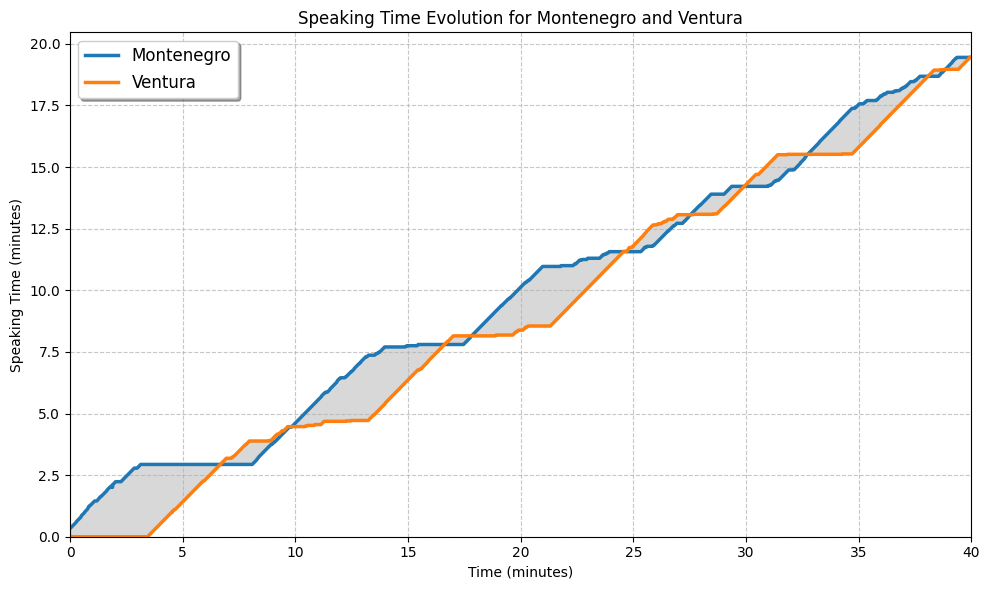

In [3]:
#Analyse and clean text
def clean_time_string(t):
   
    return t.replace('I', '1').replace('O', '0').replace('l', '1').replace('o', '0')

#first lets order the images

data = data.sort_values(by='filename')

pd.set_option('display.max_rows', None)

pattern_mo = r'\bMO\w+\b'

pattern_v = r'\bv\w+\b'

count = 0

Used_list = []


# Iterate over the rows of the DataFrame starting from index 73
for i in range(73, len(data)):

    # Extract the list from the specified column
    data_inside = data.iloc[i, 4]

    # Iterate over each string in the list
    for j in range(len(data_inside)):

        # Check if the pattern matches the string
        if re.search(pattern_mo, data_inside[j]):

            # If pattern is found, extract the current string and the next three strings
            desired_info = data_inside[j:j+4]  # Extract the next three strings

            # Translate "MO..." to "Montenegro" and "v..." to "Ventura"
            translated_info = []
            for item in desired_info:
                if re.match(pattern_mo, item):
                    translated_info.append("Montenegro")
                elif re.match(pattern_v, item):
                    translated_info.append("Ventura")
                else:
                    translated_info.append(item)

            # Append the translated_info to Used_list
            Used_list.append(translated_info)


# Filter out lists with exactly 4 objects
Used_list = [desired_info for desired_info in Used_list if len(desired_info) == 4]

# Initialize arrays to store Montenegro and Ventura times
montenegro_times = []
ventura_times = []


#spliting the time string and taking the first two and last two characters. First two --> Montenegro, Last two --> Ventura
for list in Used_list:
 
    # Get the first two characters
    first_part_m = list[1][:2]

    # Get the last two characters
    second_part_m = list[1][-2:]

    first_part_v = list[2][:2]

    second_part_v = list[2][-2:]
    
     # Join the Montenegro parts with a period in the middle
    montenegro_time = f"{first_part_m}.{second_part_m}"

    # Join the Ventura parts with a period in the middle
    ventura_time = f"{first_part_v}.{second_part_v}"
    
    # Append the times to the arrays
    montenegro_times.append(montenegro_time)
    ventura_times.append(ventura_time)

# Apply cleaning to time strings
montenegro_times_cleaned = [clean_time_string(time) for time in montenegro_times]
ventura_times_cleaned = [clean_time_string(time) for time in ventura_times]

montenegro_times_filtered = [time for time in montenegro_times_cleaned if 'VE' not in time]
ventura_times_filtered = [time for time in ventura_times_cleaned if 'VE' not in time]

montenegro_times_filtered2 = [time for time in montenegro_times_filtered if 'AD' not in time]
ventura_times_filtered2 = [time for time in ventura_times_filtered if 'AD' not in time]

montenegro_times_filtered3 = [time for time in montenegro_times_filtered2 if 'Ve' not in time]
ventura_times_filtered3 = [time for time in ventura_times_filtered2 if 'Ve' not in time]

montenegro_times_filtered4 = [time for time in montenegro_times_filtered3 if 'ª' not in time]
ventura_times_filtered4 = [time for time in ventura_times_filtered3 if 'ª' not in time]

montenegro_times_filtered5 = [time for time in montenegro_times_filtered4 if '[2' not in time]
ventura_times_filtered5 = [time for time in ventura_times_filtered4 if '[2' not in time]

montenegro_minutes = [time_str_to_float(time) for time in montenegro_times_filtered5]
ventura_minutes = [time_str_to_float(time) for time in ventura_times_filtered5]

# Assuming montenegro_minutes and ventura_minutes are available and contain speaking time in minutes for each speech turn.


########### normalizing the time of the debate ###########

total_debate_time = 40  # Total time for the debate in minutes
total_speech_turns = max(len(montenegro_minutes), len(ventura_minutes))

# Calculate the average duration per speech turn in minutes
average_duration_per_turn = total_debate_time / total_speech_turns

# Generate x-axis values corresponding to the actual time in minutes
x_axis_time = [i * average_duration_per_turn for i in range(total_speech_turns)]

########## Outlier Detection and Filtering ##########
for i in range(0, len(ventura_minutes)):
    if ventura_minutes[i] == 1.0166666666666666:
        ventura_minutes[i] = ventura_minutes[i-2]
    elif i < 750 and i > 500 and ventura_minutes[i] >= 7.5:
        ventura_minutes[i] = ventura_minutes[i-1]

#####################################################

############### plot the speaking time evolution for Montenegro and Ventura ############### 

plt.figure(figsize=(10, 6))  # Increase figure size for better visibility

# Use the same x-axis for both speakers, assuming both arrays cover the entire debate duration
plt.plot(x_axis_time[:len(montenegro_minutes)], montenegro_minutes, label='Montenegro', linewidth=2.5)
plt.plot(x_axis_time[:len(ventura_minutes)], ventura_minutes, label='Ventura', linewidth=2.5)

# Add shaded area between the lines where applicable
plt.fill_between(x_axis_time[:min(len(montenegro_minutes), len(ventura_minutes))], 
                 montenegro_minutes[:min(len(montenegro_minutes), len(ventura_minutes))], 
                 ventura_minutes[:min(len(montenegro_minutes), len(ventura_minutes))], color='grey', alpha=0.3)

# Add labels and title with more description
plt.xlabel('Time (minutes)')
plt.ylabel('Speaking Time (minutes)')
plt.title('Speaking Time Evolution for Montenegro and Ventura')

# Enhance the legend
plt.legend(loc='upper left', fontsize='large', frameon=True, shadow=True)

# Show the plot with an enhanced grid for better readability and axis range adjustment
plt.grid(True, linestyle='--', alpha=0.7)  # Enhanced grid visibility
plt.xlim(left=0, right=total_debate_time)  # Adjusted for the total duration of the debate
plt.ylim(bottom=0, top=max(max(montenegro_minutes), max(ventura_minutes)) + 1)  # Set dynamic upper limit based on max speaking time

plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()

    

Now doing the "educated" speaking time and see how much they deviate from the correct one

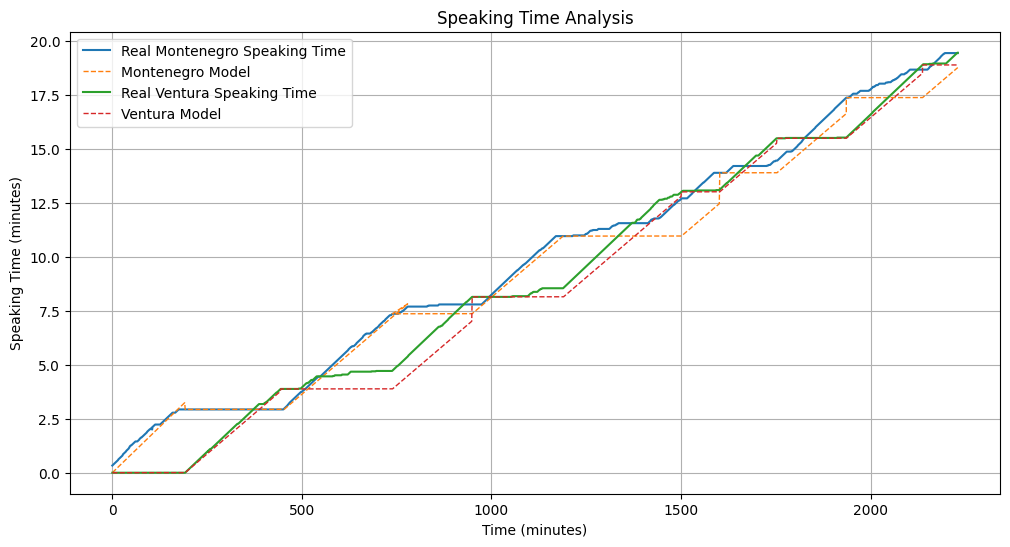

Montenegro Mean deviation: 0.3553546012177844
Ventura Mean deviation: 0.20541008267343988


In [4]:

x_values = np.array([i for i in range(len(montenegro_minutes))]) 

# Custom function setup for Montenegro
segments_montenegro = [
    (0, 191, 'l', 0.017),
    (192, 452, 'c', montenegro_minutes[193]),
    (453, 779, 'l', 0.015),
    (739, 948, 'c', montenegro_minutes[741]),
    (949, 1189, 'l', 0.015),
    (1190, 1500, 'c', montenegro_minutes[1191]),
    (1501, 1601, 'l', 0.015),
    (1602, 1752, 'c', montenegro_minutes[1604]),
    (1753, 1936, 'l', 0.015),
    (1936, 2137, 'c', montenegro_minutes[1938]), 
    (2137, 2230, 'l', 0.015)
]

# Custom function setup for Ventura
segments_ventura = [
    (0, 191, 'c', 0.0),
    (192, 443, 'l', 0.015),
    (444, 738, 'c', ventura_minutes[444]),
    (739, 948, 'l', 0.015),
    (949, 1189, 'c', ventura_minutes[949]),
    (1190, 1500, 'l', 0.015),
    (1501, 1601, 'c', ventura_minutes[1501]),
    (1602, 1752, 'l', 0.015),
    (1753, 1936, 'c', ventura_minutes[1753]),
    (1936, 2137, 'l', 0.015), 
    (2137, 2230, 'c', ventura_minutes[2137])
]


# Compute piecewise functions
x_custom_montenegro, y_custom_montenegro = calculate_custom_function_affine(segments_montenegro)
x_custom_ventura, y_custom_ventura = calculate_custom_function_affine(segments_ventura)

plt.figure(figsize=(12, 6))
plt.plot(x_values, montenegro_minutes, label='Real Montenegro Speaking Time', linewidth=1.5)  # Reduced linewidth
plt.plot(x_custom_montenegro, y_custom_montenegro, label='Montenegro Model', linestyle='--', linewidth=1)  # Reduced linewidth
plt.plot(x_values, ventura_minutes, label='Real Ventura Speaking Time',   linewidth=1.5)  # Reduced linewidth
plt.plot(x_custom_ventura, y_custom_ventura, label='Ventura Model', linewidth=1, linestyle='--')  # Reduced linewidth
plt.title('Speaking Time Analysis')
plt.xlabel('Time (minutes)')
plt.ylabel('Speaking Time (minutes)')
plt.legend()
plt.grid(True)
plt.show()


# Calculate deviations for Montenegro
f_interp_montenegro = interp1d(x_custom_montenegro, y_custom_montenegro, bounds_error=False, fill_value="extrapolate")
y_custom_interp_montenegro = f_interp_montenegro(x_values)
deviations_montenegro = np.abs(y_custom_interp_montenegro - montenegro_minutes)**2
print("Montenegro Mean deviation:", np.mean(deviations_montenegro))

# Calculate deviations for Ventura
f_interp_ventura = interp1d(x_custom_ventura, y_custom_ventura, bounds_error=False, fill_value="extrapolate")
y_custom_interp_ventura = f_interp_ventura(x_values)
deviations_ventura = np.abs(y_custom_interp_ventura - ventura_minutes)**2
print("Ventura Mean deviation:", np.mean(deviations_ventura))



Now Lets do the same for the other debates. Lets use a calmer debate

JUST THE DEBATES ON RTP HAVE THE TIME!!!!

LIVRE - PS


In [5]:
# Load the pickle file into a DataFrame
data = pd.read_pickle('pkl_files\\livre-ps.pkl')

print(data.iloc[:, 4])

0           [523, [2924, NUNEBRQTOS, 00:000O:54, TARHRES]
1             [826241, NUNEBRQTOS, 11:40, 11.33, TARHRES]
2          [23, 82624, NUNEBRQTOS, 03.51, 03.49, TARHRES]
3       [=3, ª, NUNEBRPTOS, 01.35, 01.28, TARHRES, 9, ...
4         [3, 0 ), 2124, NUNEBRQTOS, 00:000O:12, TARURES]
5             [3, 2124, NUNEBROTOS, 00:00IOO:19, TARHRES]
6       [0), RUI TAVARES, Livre, 224, NUNPEBRQTOS, 13....
7          [0)7, NUNEBRQTOS, 10.38, 09.42, TARURES, 2624]
8         [=3, 826241, NUNEBRPTOS, 13.51, 13.04, TARHRES]
9                [=3, n, DIREÇÃO DE INFORMAÇÃO, RTP 2024]
10          [[2624, NUNSBRPTOS, 05,45, 05.26, TARHRES, 2]
11       [=3, 1, NUNEBRBTOS, 06.44, 05.27, TARHRES, 2924]
12          [9), 2124, NUNEBRQTOS, 08.22, 07-45, TARHRES]
13          [1, {2124, NUNEBRQTOS, 10.38, 10.01, TARHRES]
14          [0), 2124, NUNEBRQTOS, 13.35, 12.09, TARHRES]
15         [=3, 82624, NUNEBRBTOS, 11-48, 11.33, TARURES]
16       [3, 0), 2124, NUNEBRQTOS, 10.38, 09.34, TARHRES]
17        [728

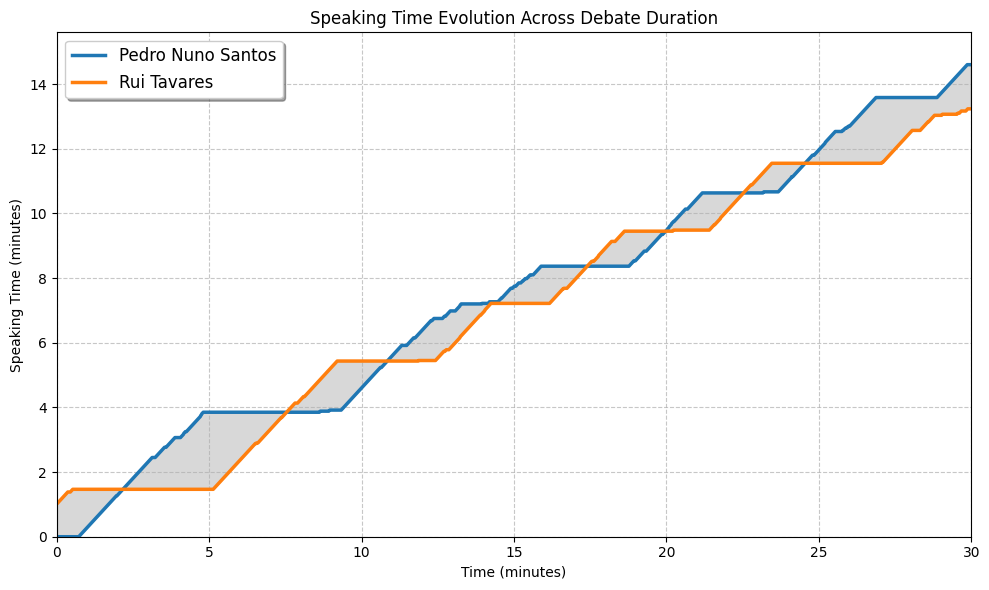

In [6]:

#first lets order the images

data = data.sort_values(by='filename')


pd.set_option('display.max_rows', None)

pattern_n = r'\bNU\w+\b'

pattern_T = r'\bTA\w+\b'

count = 0

Used_list = []


# Iterate over the rows of the DataFrame starting from index 73
for i in range(122, len(data)):

    # Extract the list from the specified column
    data_inside = data.iloc[i, 4]

    # Iterate over each string in the list
    for j in range(len(data_inside)):

        # Check if the pattern matches the string
        if re.search(pattern_n, data_inside[j]):
            

            # If pattern is found, extract the current string and the next three strings
            desired_info = data_inside[j:j+4]  # Extract the next three strings

            translated_info = []
            for item in desired_info:
                if re.match(pattern_n, item):
                    translated_info.append("Pedro Nuno Santos")
                elif re.match(pattern_T, item):
                    translated_info.append("Rui Tavares")
                else:
                    translated_info.append(item)

            # Append the translated_info to Used_list
            Used_list.append(translated_info)


# Filter out lists with exactly 4 objects
Used_list = [desired_info for desired_info in Used_list if len(desired_info) == 4]

Used_list = [sublist for sublist in Used_list if "PEDRO NUNO SANTOS" not in sublist]


# Initialize arrays to store times
PNS_times = []
Rui_times = []


for list in Used_list:
 
    # Get the first two characters
    first_part_m = list[1][:2]

    # Get the last two characters
    second_part_m = list[1][-2:]

    first_part_v = list[2][:2]

    second_part_v = list[2][-2:]
    
     # Join the PNS parts with a period in the middle
    PNS_time = f"{first_part_m}.{second_part_m}"

    # Join the Tavares parts with a period in the middle
    Rui_time = f"{first_part_v}.{second_part_v}"
    
    # Append the times to the arrays
    PNS_times.append(PNS_time)
    Rui_times.append(Rui_time)


PNS_times = [time.replace('O', '0').replace('I', '1').replace('l', '1') for time in PNS_times]
Rui_times = [time.replace('O', '0').replace('I', '1').replace('l', '1') for time in Rui_times]

# Filter out any strings that contain 'Ru'
PNS_times_filtered = [time for time in PNS_times if 'Ru' not in time]
Rui_times_filtered = [time for time in Rui_times if 'Ru' not in time]

# Filter out any strings that contain '1q'
Rui_times_filtered1 = [time for time in Rui_times_filtered if '1q' not in time]

PNS_minutes = [time_str_to_float(time) for time in PNS_times_filtered]
Rui_minutes = [time_str_to_float(time) for time in Rui_times_filtered1]

total_debate_time = 30

total_speech_turns = max(len(PNS_minutes), len(Rui_minutes))

# Calculate the average duration per speech turn in minutes
average_duration_per_turn = total_debate_time / total_speech_turns

# Generate x-axis values corresponding to the actual time in minutes
x_axis_time = [i * average_duration_per_turn for i in range(total_speech_turns)]

# Use the same x-axis for both speakers, assuming both arrays cover the entire debate duration
plt.figure(figsize=(10, 6))
plt.plot(x_axis_time[:len(PNS_minutes)], PNS_minutes, label='Pedro Nuno Santos', linewidth=2.5)
plt.plot(x_axis_time[:len(Rui_minutes)], Rui_minutes, label='Rui Tavares', linewidth=2.5)

# Optionally add shaded area between the lines
plt.fill_between(x_axis_time[:min(len(PNS_minutes), len(Rui_minutes))], 
                 PNS_minutes[:min(len(PNS_minutes), len(Rui_minutes))], 
                 Rui_minutes[:min(len(PNS_minutes), len(Rui_minutes))], color='grey', alpha=0.3)

# Setting up the plot with labels and title
plt.xlabel('Time (minutes)')
plt.ylabel('Speaking Time (minutes)')
plt.title('Speaking Time Evolution Across Debate Duration')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize='large', frameon=True, shadow=True)

# Adjust the x-axis and y-axis limits to fit the data
plt.xlim(0, total_debate_time)
plt.ylim(0, max(max(PNS_minutes), max(Rui_minutes)) + 1)

plt.tight_layout()
plt.show()





Now again, the "educated" speaking time

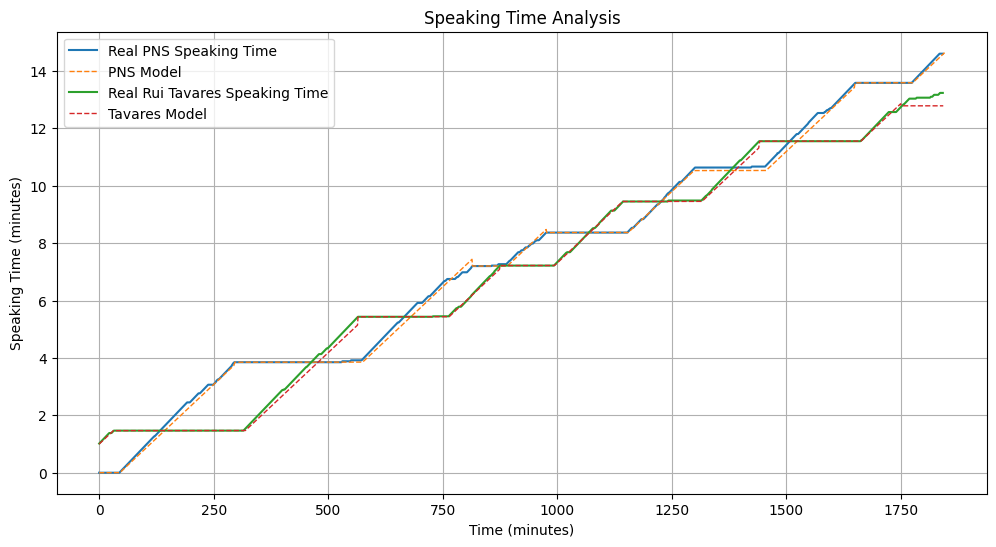

PNS Mean deviation: 0.012809531937661977
Rui Tavares Mean deviation: 0.011218175378308319


In [7]:

x_values1 = np.array([i for i in range(len(PNS_minutes))]) #Vai até 2230


# Custom function setup for Montenegro
segments_PNS = [
    (0, 44, 'c', 0.0),
    (45, 294, 'l', 0.015),
    (296, 574, 'c', PNS_minutes[298]),
    (575, 814, 'l', 0.015),
    (815, 890, 'c', PNS_minutes[820]),
    (891, 976, 'l', 0.015),
    (977, 1154, 'c', PNS_minutes[980]),
    (1155, 1299, 'l', 0.015),
    (1456, 1649, 'l',0.015),
    (1650, 1775, 'c', PNS_minutes[1656]), 
    (1776, 1846, 'l', 0.015)
]

# Custom function setup for Ventura
segments_Rui = [
    (0, 31, 'l', (0.015, 1)),
    (32, 318, 'c', Rui_minutes[35]),
    (319, 564, 'l', 0.015),
    (565, 763, 'c', Rui_minutes[568]),
    (764, 874, 'l', 0.015),
    (875, 993, 'c', Rui_minutes[878]),
    (994, 1143, 'l', 0.015),
    (1144, 1315, 'c', Rui_minutes[1146]),
    (1316, 1440, 'l', 0.015),
    (1442, 1662, 'c', Rui_minutes[1444]),
    (1663, 1750, 'l', 0.015),
    (1751, 1843, 'c', Rui_minutes[1753])
]

# Compute piecewise functions
x_custom_PNS, y_custom_PNS = calculate_custom_function_affine(segments_PNS)
x_custom_Rui, y_custom_Rui = calculate_custom_function_affine(segments_Rui)

plt.figure(figsize=(12, 6))
plt.plot(x_values1, PNS_minutes, label='Real PNS Speaking Time', linewidth=1.5)  # Reduced linewidth
plt.plot(x_custom_PNS, y_custom_PNS, label='PNS Model', linestyle='--', linewidth=1)  # Reduced linewidth
plt.plot(x_values1, Rui_minutes, label='Real Rui Tavares Speaking Time',   linewidth=1.5)  # Reduced linewidth
plt.plot(x_custom_Rui, y_custom_Rui, label='Tavares Model', linewidth=1, linestyle='--')  # Reduced linewidth
plt.title('Speaking Time Analysis')
plt.xlabel('Time (minutes)')
plt.ylabel('Speaking Time (minutes)')
plt.legend()
plt.grid(True)
plt.show()


# Calculate deviations for PNS
f_interp_PNS = interp1d(x_custom_PNS, y_custom_PNS, bounds_error=False, fill_value="extrapolate")
y_custom_interp_PNS = f_interp_PNS(x_values1)
deviations_PNS = np.abs(y_custom_interp_PNS - PNS_minutes)**2
print("PNS Mean deviation:", np.mean(deviations_PNS))


#Calculate deviations for Rui
f_interp_Rui = interp1d(x_custom_Rui, y_custom_Rui, bounds_error=False, fill_value="extrapolate")
y_custom_interp_Rui = f_interp_Rui(x_values1)
deviations_Rui = np.abs(y_custom_interp_Rui - Rui_minutes)**2
print("Rui Tavares Mean deviation:", np.mean(deviations_Rui))

BE - PS

In [8]:
# Load the pickle file into a DataFrame
data = pd.read_pickle('pkl_files\\be-ps.pkl')


['00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', '00.00', 'BE.BE', '00.01', 'BE.BE', '00.02', 'BE.BE', '00.03', 'BE.BE', '00.04', 'BE.BE', '00.05', '00.06', '00.07', '00.08', '00.09', '00.10', '00.11', '00.12', '00.13', '00.14', '00.15', '00.16', '00.17', '00.18', '00.19', '00.20', '00.21', '00.22', '00.23', '00.24', '00.25', '00.26', '00.27', '00.28', '00.29', 'PE.R0', '00.30', '00.31', '00.32', '00.33', '00.34', '00.35', '00.36', '00.37', '00.38', '00.39', '00.39', '00.39', '00.39', '00.39', '00.39', '00.39', '00.39', '00.39', '00.40', '00.41', '00.42', '00.43', '00.44', '00.45', '00.46', '00.47', '00.48', '00.49', '00.50', '00.51', '00.52', '00.53', '00.54', '00.55', '00.56', '00.57', '00.58', '00.59', '01.00', 

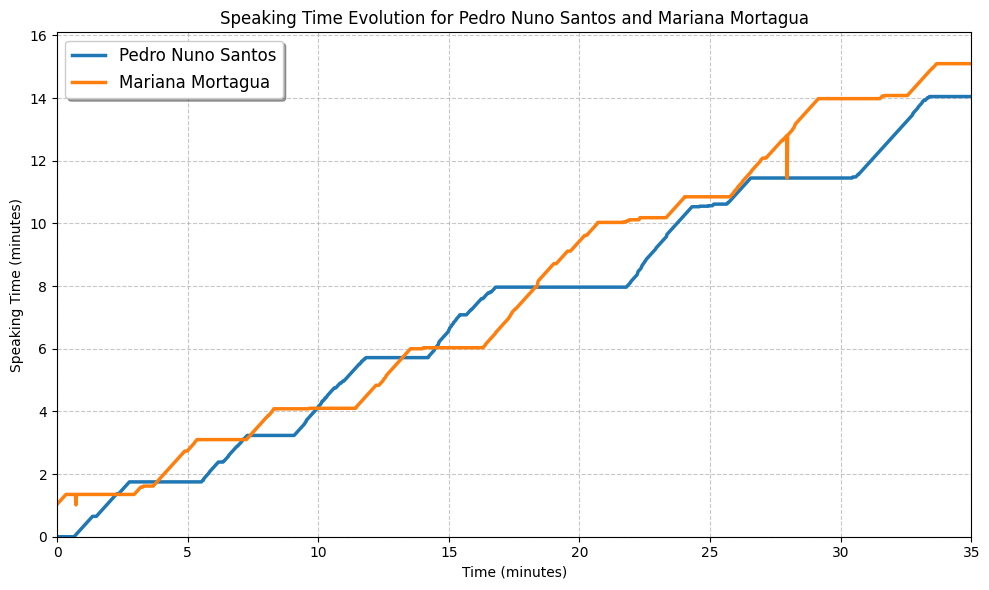

In [9]:
#Analyse and clean text

#first lets order the images

data = data.sort_values(by='filename')


pd.set_option('display.max_rows', None)

pattern_n = r'\bN\w+\b'

pattern_m = r'\bM\w+\b'

count = 0

Used_list = []


# Iterate over the rows of the DataFrame starting from index 73
for i in range(119, len(data)):

    # Extract the list from the specified column
    data_inside = data.iloc[i, 4]

    # Iterate over each string in the list
    for j in range(len(data_inside)):

        # Check if the pattern matches the string
        if re.search(pattern_m, data_inside[j]):
            

            # If pattern is found, extract the current string and the next three strings
            desired_info = data_inside[j:j+4]  # Extract the next three strings
            translated_info = []
            for item in desired_info:
                if re.match(pattern_m, item):
                    translated_info.append("Mariana Mortágua")
                elif re.match(pattern_n, item):
                    translated_info.append("Pedro Nuno Santos")
                else:
                    translated_info.append(item)

            # Append the translated_info to Used_list
            Used_list.append(translated_info)


# Filter out lists with exactly 4 objects
Used_list = [desired_info for desired_info in Used_list if len(desired_info) == 4]

Used_list = [sublist for sublist in Used_list if "PEDRO NUNO SANTOS" not in sublist]


# Initialize arrays to store times
PNS_times2 = []
Mortagua_times = []


for list in Used_list:
 
    # Get the first two characters
    first_part_m = list[1][:2]

    # Get the last two characters
    second_part_m = list[1][-2:]

    first_part_v = list[2][:2]

    second_part_v = list[2][-2:]
    
     # Join the PNS parts with a period in the middle
    PNS_time1 = f"{first_part_m}.{second_part_m}"

    # Join the Mortagua parts with a period in the middle
    Mortagua_time = f"{first_part_v}.{second_part_v}"
    
    # Append the times to the arrays
    PNS_times2.append(PNS_time1)
    Mortagua_times.append(Mortagua_time)


PNS_times2 = [time.replace('O', '0').replace('I', '1').replace('l', '1') for time in PNS_times2]
Mortagua_times = [time.replace('O', '0').replace('I', '1').replace('l', '1') for time in Mortagua_times]

print(PNS_times2)
print(Mortagua_times)

PNS_times_filtered1 = [time for time in PNS_times2 if 'BE' not in time and 'PE' not in time and 'Pe' not in time and 'Ma' not in time]
Mortagua_times_filtered = [time for time in Mortagua_times if 'Ru' not in time and 'os' not in time and 'oS' not in  time and '0S' not in time and ' |' not in time and ' /' not in time and 's ' not in time and ' !' not in time and 'Ma' not in time and 's_' not in time and '1b' not in time]

print(PNS_times_filtered1)
print(Mortagua_times_filtered)

# Now the conversion again
PNS_minutes_filtered2 = [time_str_to_float(time) for time in PNS_times_filtered1]
Mortagua_minutes_filtered = [time_str_to_float(time) for time in Mortagua_times_filtered]


#############################################  Outliers Detection  #############################################

# New lists to store the filtered results
PNS_minutes_filtered2_no_outliers = []
Mortagua_minutes_filtered_no_outliers = []

for index, time in enumerate(Mortagua_minutes_filtered):
    if index < 500 and time <= 6:
        Mortagua_minutes_filtered_no_outliers.append(time)
    elif 500 <= index < 1000:
        Mortagua_minutes_filtered_no_outliers.append(time)
    elif 1000 <= index < 1250 and time >= 6:
        Mortagua_minutes_filtered_no_outliers.append(time)
    elif index >= 1250:
        Mortagua_minutes_filtered_no_outliers.append(time)

PNS_minutes_filtered2 = PNS_minutes_filtered2[:len(Mortagua_minutes_filtered_no_outliers)] 

####################################### Plot the Filtered Data with Outliers Removed  #######################################

# Assume PNS_minutes_filtered2 and Mortagua_minutes_filtered_no_outliers are available and contain filtered data.

total_debate_time = 35  # Total time for the debate in minutes
total_speech_turns = max(len(PNS_minutes_filtered2), len(Mortagua_minutes_filtered_no_outliers))

# Calculate the average duration per speech turn in minutes
average_duration_per_turn = total_debate_time / total_speech_turns

# Generate x-axis values corresponding to the actual time in minutes
x_axis_time = [i * average_duration_per_turn for i in range(total_speech_turns)]

plt.figure(figsize=(10, 6))  # Increased figure size for better visibility

# Use the same x-axis for both speakers, assuming both arrays cover the entire debate duration
plt.plot(x_axis_time[:len(PNS_minutes_filtered2)], PNS_minutes_filtered2, label='Pedro Nuno Santos', linewidth=2.5)
plt.plot(x_axis_time[:len(Mortagua_minutes_filtered_no_outliers)], Mortagua_minutes_filtered_no_outliers, label='Mariana Mortagua', linewidth=2.5)

# Add labels and title with more description
plt.xlabel('Time (minutes)')
plt.ylabel('Speaking Time (minutes)')
plt.title('Speaking Time Evolution for Pedro Nuno Santos and Mariana Mortagua')

# Enhance the legend
plt.legend(loc='upper left', fontsize='large', frameon=True, shadow=True)

# Show the plot with an enhanced grid for better readability and axis range adjustment
plt.grid(True, linestyle='--', alpha=0.7)  # Enhanced grid visibility
plt.xlim(left=0, right=total_debate_time)  # Adjusted for the total duration of the debate
plt.ylim(bottom=0, top=max(max(PNS_minutes_filtered2), max(Mortagua_minutes_filtered_no_outliers)) + 1)  # Set dynamic upper limit based on max speaking time

plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()


Evaluate the rudness of each politic

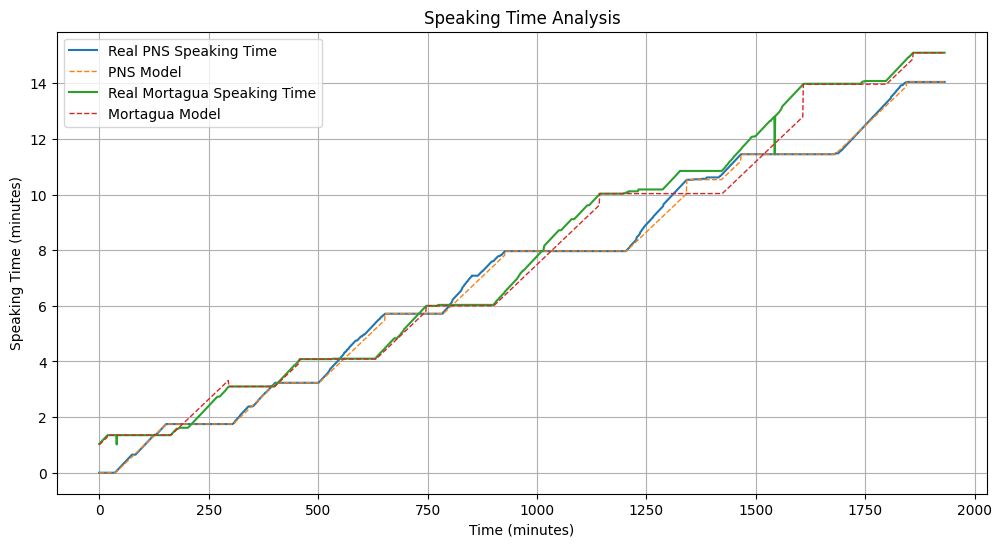

PNS Mean deviation: 0.7669147936082021
Mortagua Mean deviation: 0.15439352858293082


In [10]:

x_values2 = np.array([i for i in range(len(Mortagua_minutes_filtered_no_outliers))]) #Vai até 2230

'''for i in range(len(Mortagua_minutes_filtered_no_outliers)):
    print(f"the number {i} of {Mortagua_minutes_filtered_no_outliers[i]}")
'''

segments_PNS1 = [
    (0, 36, 'c', 0.0),       # Corrected indices and type from your first set
    (37, 152, 'l', 0.015),    # Continued with corrected types and formats
    (153, 305, 'c', PNS_minutes_filtered2[153]),
    (306, 402, 'l', 0.015),
    (403, 501, 'c', PNS_minutes_filtered2[403]),
    (502, 652, 'l', 0.015),
    (653, 785, 'c', PNS_minutes_filtered2[653]),
    (786, 926, 'l', 0.015),
    (927, 1203, 'c', PNS_minutes_filtered2[927]),
    (1204, 1341, 'l', 0.015),
    (1342, 1420, 'c', PNS_minutes_filtered2[1342]),
    (1421, 1465, 'l', 0.015),
    (1466, 1680, 'c', PNS_minutes_filtered2[1466]),
    (1681, 1843, 'l', 0.015),
    (1844, 1933, 'c', PNS_minutes_filtered2[1844]),
    (1934, 2005, 'l', 0.015)
]

segments_Mortagua = [
    (0, 18, 'l', (0.015, 1)),
    (19, 163, 'c', Mortagua_minutes_filtered_no_outliers[19]),
    (164, 295, 'l', 0.015),
    (296, 400, 'c', Mortagua_minutes_filtered_no_outliers[296]),
    (401, 457, 'l', 0.015),
    (458, 631, 'c', Mortagua_minutes_filtered_no_outliers[458]),
    (632, 746, 'l', 0.015),
    (747, 900, 'c', Mortagua_minutes_filtered_no_outliers[747]),
    (901, 1142, 'l', 0.015),
    (1143, 1422, 'c', Mortagua_minutes_filtered_no_outliers[1143]),
    (1423, 1607, 'l', 0.015),
    (1608, 1797, 'c', Mortagua_minutes_filtered_no_outliers[1608]),
    (1798, 1858, 'l', 0.015),
    (1859, 1931, 'c', Mortagua_minutes_filtered_no_outliers[1859])
]


# Compute piecewise functions
x_custom_PNS1, y_custom_PNS1 = calculate_custom_function_affine(segments_PNS1)
x_custom_Mortagua, y_custom_Mortagua = calculate_custom_function_affine(segments_Mortagua)

x_custom_PNS1 = np.array(x_custom_PNS1)
y_custom_PNS1 = np.array(y_custom_PNS1)

# Find the end time from the Mortagua model to limit the PNS model plot
end_time = x_custom_Mortagua[-1]  # Get the last time point of the Mortagua model
mask = x_custom_PNS1 <= end_time  # Create a mask for all points in PNS model <= end time of Mortagua model

# Apply mask
truncated_x_custom_PNS1 = x_custom_PNS1[mask]
truncated_y_custom_PNS1 = y_custom_PNS1[mask]

plt.figure(figsize=(12, 6))
plt.plot(x_values2, PNS_minutes_filtered2, label='Real PNS Speaking Time', linewidth=1.5)  # Plot full PNS data
plt.plot(truncated_x_custom_PNS1, truncated_y_custom_PNS1, label='PNS Model', linestyle='--', linewidth=1)  # Plot truncated PNS model data
plt.plot(x_values2, Mortagua_minutes_filtered_no_outliers, label='Real Mortagua Speaking Time', linewidth=1.5)  # Plot full Mortagua data
plt.plot(x_custom_Mortagua, y_custom_Mortagua, label='Mortagua Model', linewidth=1, linestyle='--')  # Plot full Mortagua model data
plt.title('Speaking Time Analysis')
plt.xlabel('Time (minutes)')
plt.ylabel('Speaking Time (minutes)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate deviations for PNS
f_interp_PNS1 = interp1d(truncated_x_custom_PNS1, truncated_y_custom_PNS1, bounds_error=False, fill_value="extrapolate")
y_custom_interp_PNS1 = f_interp_PNS(x_values2)
deviations_PNS1 = np.abs(y_custom_interp_PNS1 - PNS_minutes_filtered2)**2
print("PNS Mean deviation:", np.mean(deviations_PNS1))

# Calculate deviations for Mortagua
f_interp_Mortagua = interp1d(x_custom_Mortagua, y_custom_Mortagua, bounds_error=False, fill_value="extrapolate")
y_custom_interp_Mortagua = f_interp_Mortagua(x_values2)
deviations_Mortagua = np.abs(y_custom_interp_Mortagua - Mortagua_minutes_filtered_no_outliers)**2
print("Mortagua Mean deviation:", np.mean(deviations_Mortagua))


NOW CHEGA VS BE

In [11]:
# Load the pickle file into a DataFrame
data = pd.read_pickle('pkl_files\\chega-be.pkl')


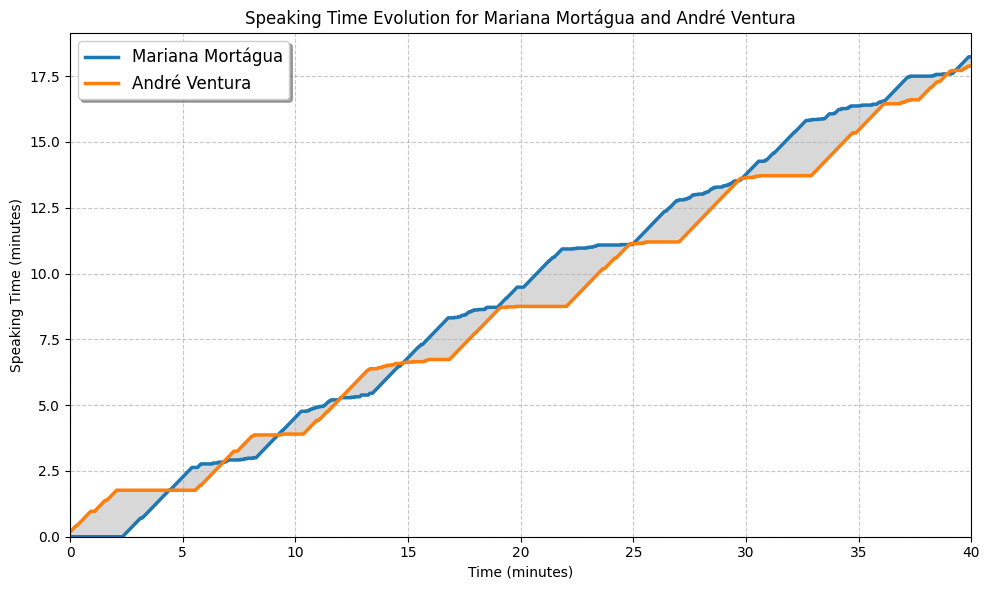

In [12]:
#first lets order the images

data = data.sort_values(by='filename')

count = 0

pd.set_option('display.max_rows', None)

Used_list = []

# Iterate over the rows of the DataFrame starting from index 73
for i in range(53, 2184):

    # Extract the list from the specified column
    data_inside = data.iloc[i, 4]

    # Iterate over each string in the list
    for j in range(len(data_inside)):

        # Check if the pattern matches the string
        if re.search(pattern_m, data_inside[j]):
            

            # If pattern is found, extract the current string and the next three strings
            desired_info = data_inside[j:j+4]  # Extract the next three strings

            translated_info = []
            for item in desired_info:
                if re.match(pattern_m, item):
                    translated_info.append("Mariana Mortágua")
                elif re.match(pattern_v, item):
                    translated_info.append("André Ventura")
                else:
                    translated_info.append(item)

            # Append the translated_info to Used_list
            Used_list.append(translated_info)


# Filter out lists with exactly 4 objects
Used_list = [desired_info for desired_info in Used_list if len(desired_info) == 4]


# Initialize arrays to store times
Andre_times = []
Mariana_times = []


for list in Used_list:
 
    # Get the first two characters
    first_part_m = list[1][:2]

    # Get the last two characters
    second_part_m = list[1][-2:]

    first_part_v = list[2][:2]

    second_part_v = list[2][-2:]
    
     # Join the Ventura parts with a period in the middle
    Andre_time = f"{first_part_m}.{second_part_m}"

    # Join the Mortagua parts with a period in the middle
    Mariana_time = f"{first_part_v}.{second_part_v}"
    
    # Append the times to the arrays
    Mariana_times.append(Mariana_time)
    Andre_times.append(Andre_time)


Mariana_times = [time.replace('O', '0').replace('I', '1').replace('l', '1') for time in Mariana_times]
Andre_times = [time.replace('O', '0').replace('I', '1').replace('l', '1') for time in Andre_times]


Mariana_times_filtered = [time for time in Mariana_times if '{2' not in time and '[2' not in time and '0]' not in time and '@' not in time and 'BE' not in time]
Andre_times_filtered = [time for time in Andre_times if 'BE' not in time and 'AN' not in time ]


Mariana_minutes_filtered = [time_str_to_float(time) for time in Mariana_times_filtered]
Andre_minutes_filtered = [time_str_to_float(time) for time in Andre_times_filtered]


#############################################  Outliers Detection  #############################################
# New lists to store the filtered results
Mariana_minutes_filtered_no_outliers = []

for index, time in enumerate(Mariana_minutes_filtered):
    if index < 1000:
        Mariana_minutes_filtered_no_outliers.append(time)
    elif 1000 <= index < 1250 and time <= 15 and time >= 5:
        Mariana_minutes_filtered_no_outliers.append(time)
    elif index >= 1250 :
        Mariana_minutes_filtered_no_outliers.append(time)
   
Andre_minutes_filtered = Andre_minutes_filtered[:len(Mariana_minutes_filtered_no_outliers)]
####################################### Plot the Filtered Data with Outliers Removed  #######################################

total_debate_time = 40  # Assuming the total time for the debate in minutes
total_speech_turns = max(len(Mariana_minutes_filtered_no_outliers), len(Andre_minutes_filtered))

# Calculate the average duration per speech turn in minutes, if you have a total count of turns
average_duration_per_turn = total_debate_time / total_speech_turns

# Generate x-axis values corresponding to the actual time in minutes
x_axis_time = [i * average_duration_per_turn for i in range(total_speech_turns)]

plt.figure(figsize=(10, 6))  # Specify the figure size for better visibility

# Use the generated x-axis for both speakers to show actual time distribution across the debate
plt.plot(x_axis_time[:len(Mariana_minutes_filtered_no_outliers)], Mariana_minutes_filtered_no_outliers, label='Mariana Mortágua', linewidth=2.5)
plt.plot(x_axis_time[:len(Andre_minutes_filtered)], Andre_minutes_filtered, label='André Ventura', linewidth=2.5)

plt.fill_between(x_axis_time[:min(len(Mariana_minutes_filtered_no_outliers), len(Andre_minutes_filtered))], 
                  Mariana_minutes_filtered_no_outliers[:min(len(Mariana_minutes_filtered_no_outliers), len(Andre_minutes_filtered))], 
                  Andre_minutes_filtered[:min(len(Mariana_minutes_filtered_no_outliers), len(Andre_minutes_filtered))], color='grey', alpha=0.3)

# Add labels and title with more description
plt.xlabel('Time (minutes)')
plt.ylabel('Speaking Time (minutes)')
plt.title('Speaking Time Evolution for Mariana Mortágua and André Ventura')

# Enhance the legend
plt.legend(loc='upper left', fontsize='large', frameon=True, shadow=True)

# Show the plot with an enhanced grid for better readability and axis range adjustment
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(left=0, right=total_debate_time)  # Adjust x-axis to cover the total debate duration
plt.ylim(bottom=0)  # Start y-axis at zero

plt.tight_layout()  # Adjust layout to fit elements neatly
plt.show()




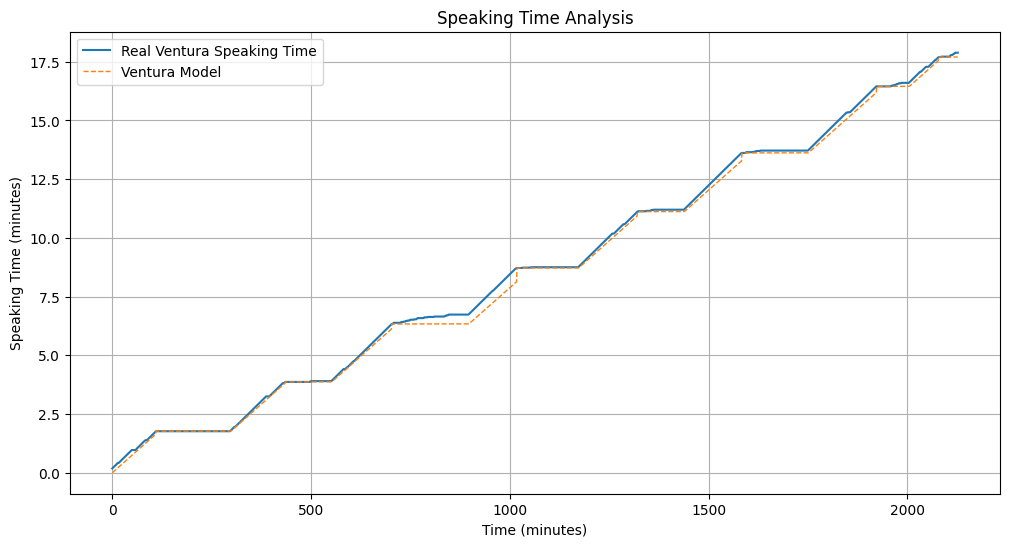

Ventura Mean deviation: 0.03610003002297413


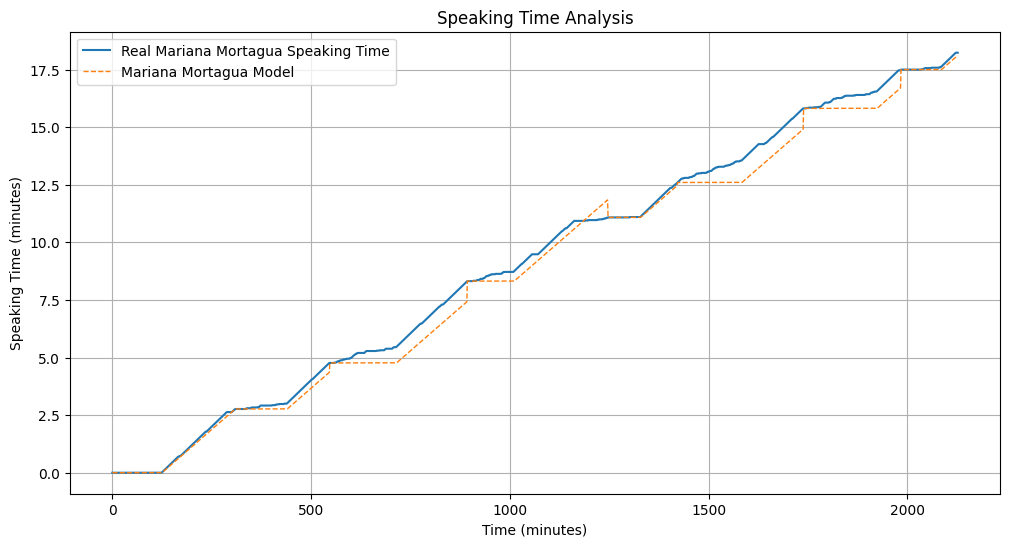

Mariana Mortagua Mean deviation: 0.21668588398078545


In [13]:

x_values3 = np.array([i for i in range(len(Mariana_minutes_filtered_no_outliers))]) #Vai até 2230


segments_Mariana = [
    (0, 124, 'c', Mariana_minutes_filtered_no_outliers[0]),
    (125, 309, 'l', 0.015),
    (310, 439, 'c', Mariana_minutes_filtered_no_outliers[310]),
    (440, 546, 'l', 0.015),
    (547, 714, 'c', Mariana_minutes_filtered_no_outliers[547]),
    (715, 892, 'l', 0.015),
    (893, 1010, 'c', Mariana_minutes_filtered_no_outliers[893]),
    (1011, 1246, 'l', 0.015),
    (1247, 1328, 'c', Mariana_minutes_filtered_no_outliers[1247]),
    (1329, 1421, 'l', 0.015),  # corrected overlapping range from 1328 to 1329
    (1422, 1583, 'c', Mariana_minutes_filtered_no_outliers[1422]),
    (1584, 1738, 'l', 0.015),
    (1739, 1923, 'c', Mariana_minutes_filtered_no_outliers[1739]),
    (1924, 1983, 'l', 0.015),
    (1984, 2085, 'c', Mariana_minutes_filtered_no_outliers[1984]),  # corrected overlapping range from 1983 to 1984
    (2086, 2127, 'l', 0.015)  # corrected overlapping range from 2085 to 2086
]

segments_Andre = [
    (0, 109, 'l', 0.015),
    (110, 297, 'c', Andre_minutes_filtered[110]),
    (298, 434, 'l', 0.015),
    (435, 551, 'c', Andre_minutes_filtered[435]),
    (552, 702, 'l', 0.015),
    (703, 896, 'c', Andre_minutes_filtered[703]),
    (897, 1017, 'l', 0.015),
    (1018, 1172, 'c', Andre_minutes_filtered[1018]),
    (1173, 1320, 'l', 0.015),
    (1321, 1438, 'c', Andre_minutes_filtered[1321]),
    (1439, 1583, 'l', 0.015),
    (1584, 1750, 'c', Andre_minutes_filtered[1584]),
    (1751, 1922, 'l', 0.015),
    (1923, 2004, 'c', Andre_minutes_filtered[1923]),
    (2005, 2078, 'l', 0.015),
    (2079, 2129, 'c', Andre_minutes_filtered[2079])
]


# Compute piecewise functions
x_custom_Andre, y_custom_Andre = calculate_custom_function_affine(segments_Andre)
x_custom_Mariana, y_custom_Mariana = calculate_custom_function_affine(segments_Mariana)

if len(x_custom_Andre) > len(x_custom_Mariana):
    x_custom_Andre = x_custom_Andre[0:len(x_custom_Mariana)]
    y_custom_Andre = y_custom_Andre[0:len(y_custom_Mariana)]


plot_and_analyze_speaking_time(x_values3, Andre_minutes_filtered, x_custom_Andre, y_custom_Andre, "Ventura")
plot_and_analyze_speaking_time(x_values3, Mariana_minutes_filtered_no_outliers, x_custom_Mariana, y_custom_Mariana, "Mariana Mortagua")






CHEGA VS PAN

In [14]:
# Load the pickle file into a DataFrame
data = pd.read_pickle('pkl_files\\pan-chega.pkl')

[1.0166666666666666, 1.0333333333333334, 1.05, 1.05, 1.0666666666666667, 1.0833333333333333, 1.1, 1.1166666666666667, 1.1333333333333333, 1.15, 1.1666666666666667, 1.1833333333333333, 1.2, 1.2166666666666668, 1.2333333333333334, 1.25, 1.2666666666666666, 1.2833333333333332, 1.3, 1.3166666666666667, 1.3333333333333333, 1.35, 1.3666666666666667, 1.3833333333333333, 1.4, 1.4166666666666667, 1.4333333333333333, 1.45, 1.4666666666666668, 1.4833333333333334, 1.5, 1.5166666666666666, 1.5166666666666666, 1.5333333333333332, 1.5333333333333332, 1.55, 1.5666666666666667, 1.5833333333333335, 1.5833333333333335, 1.6, 1.6166666666666667, 1.6333333333333333, 1.65, 1.6666666666666665, 1.6833333333333333, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7166666666666668, 1.7333333333333334, 1.75, 1.7666666666666666, 1.7833333333333332, 1.8, 1.8166666666666667, 1.8333333333333335, 1.85, 1.8666666666666667, 1.8833333333333333, 1.9, 1.9166666666666665, 1.9333333333333333, 1.95, 1.9666666666666668

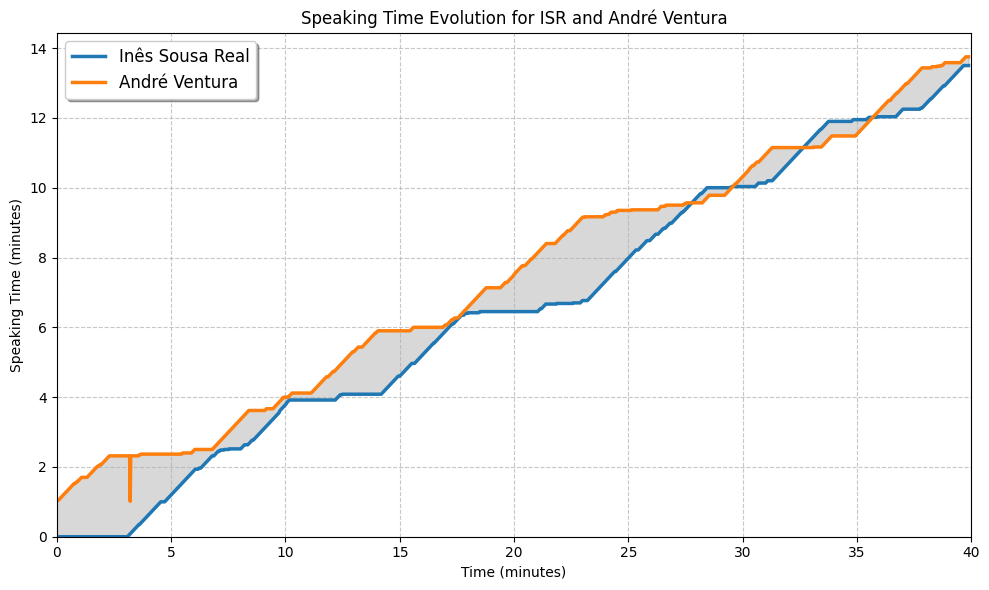

In [15]:


#first lets order the images

data = data.sort_values(by='filename')

count = 0

pd.set_option('display.max_rows', None)

pattern_ISR= r'\bSO\w+\b'

Used_list = []


# Iterate over the rows of the DataFrame starting from index 73
for i in range(150, len(data)):

    # Extract the list from the specified column
    data_inside = data.iloc[i, 4]

    # Iterate over each string in the list
    for j in range(len(data_inside)):

        # Check if the pattern matches the string
        if re.search(pattern_ISR, data_inside[j]):
            

            # If pattern is found, extract the current string and the next three strings
            desired_info = data_inside[j:j+4]  # Extract the next three strings

            translated_info = []
            for item in desired_info:
                if re.match(pattern_ISR, item):
                    translated_info.append("Inês Sousa Real")
                elif re.match(pattern_v, item):
                    translated_info.append("André Ventura")
                else:
                    translated_info.append(item)

            # Append the translated_info to Used_list
            Used_list.append(translated_info)


# Filter out lists with exactly 4 objects
Used_list = [desired_info for desired_info in Used_list if len(desired_info) == 4]

# Initialize arrays to store times
AndreVentura_times = []
ISR_times = []


for list in Used_list:
 
    # Get the first two characters
    first_part_m = list[1][:2]

    # Get the last two characters
    second_part_m = list[1][-2:]

    first_part_v = list[2][:2]

    second_part_v = list[2][-2:]
    
     # Join the ISR parts with a period in the middle
    ISR_time = f"{first_part_m}.{second_part_m}"

    # Join the Ventura parts with a period in the middle
    AndreVentura_time = f"{first_part_v}.{second_part_v}"
    
    # Append the times to the arrays
    AndreVentura_times.append(AndreVentura_time)
    ISR_times.append(ISR_time)


ISR_times = [time.replace('O', '0').replace('I', '1').replace('l', '1') for time in ISR_times]
AndreVentura_times = [time.replace('O', '0').replace('I', '1').replace('l', '1') for time in AndreVentura_times]


ISR_times_filtered = [time for time in ISR_times if '"1' not in time and 'oi' not in time and '1n' not in time and 'Go' not in time and 'PA' not in time]
AndreVentura_times_filtered = [time for time in AndreVentura_times if '{2' not in time and '0]' not in time and 'oi' not in time and 'Go']


ISR_minutes_filtered = [time_str_to_float(time) for time in ISR_times_filtered]
AndreVentura_minutes_filtered = [time_str_to_float(time) for time in AndreVentura_times_filtered]

print(AndreVentura_minutes_filtered)
print(ISR_minutes_filtered)


total_debate_time = 40  # Assuming the total time for the debate in minutes
total_speech_turns = max(len(ISR_minutes_filtered), len(AndreVentura_minutes_filtered))

# Calculate the average duration per speech turn in minutes, if you have a total count of turns
average_duration_per_turn = total_debate_time / total_speech_turns

# Generate x-axis values corresponding to the actual time in minutes
x_axis_time = [i * average_duration_per_turn for i in range(total_speech_turns)]

for i in range(0, len(AndreVentura_minutes_filtered)):
    if AndreVentura_minutes_filtered[i] == 82.4:
        AndreVentura_minutes_filtered[i] = AndreVentura_minutes_filtered[i-1]

AndreVentura_minutes_filtered = AndreVentura_minutes_filtered[:len(ISR_minutes_filtered)]

plt.figure(figsize=(10, 6))  # Specify the figure size for better visibility

# Use the generated x-axis for both speakers to show actual time distribution across the debate
plt.plot(x_axis_time[:len(ISR_minutes_filtered)], ISR_minutes_filtered, label='Inês Sousa Real', linewidth=2.5)
plt.plot(x_axis_time[:len(AndreVentura_minutes_filtered)], AndreVentura_minutes_filtered, label='André Ventura', linewidth=2.5)

plt.fill_between(x_axis_time[:min(len(ISR_minutes_filtered), len(AndreVentura_minutes_filtered))], 
                  ISR_minutes_filtered[:min(len(ISR_minutes_filtered), len(AndreVentura_minutes_filtered))], 
                  AndreVentura_minutes_filtered[:min(len(ISR_minutes_filtered), len(AndreVentura_minutes_filtered))], color='grey', alpha=0.3)

# Add labels and title with more description
plt.xlabel('Time (minutes)')
plt.ylabel('Speaking Time (minutes)')
plt.title('Speaking Time Evolution for ISR and André Ventura')

# Enhance the legend
plt.legend(loc='upper left', fontsize='large', frameon=True, shadow=True)

# Show the plot with an enhanced grid for better readability and axis range adjustment
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(left=0, right=total_debate_time)  # Adjust x-axis to cover the total debate duration
plt.ylim(bottom=0)  # Start y-axis at zero

plt.tight_layout()  # Adjust layout to fit elements neatly
plt.show()

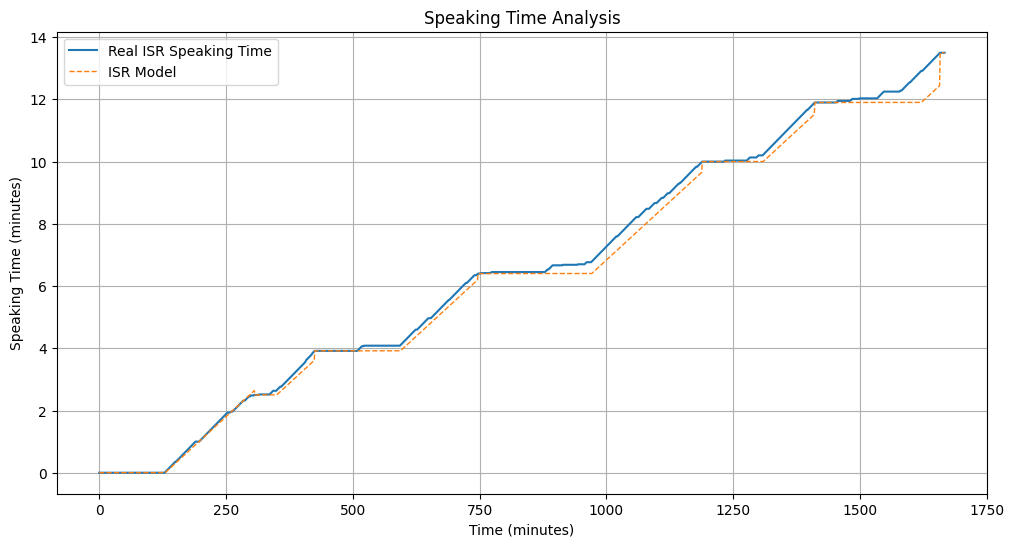

ISR Mean deviation: 0.0765340777378097


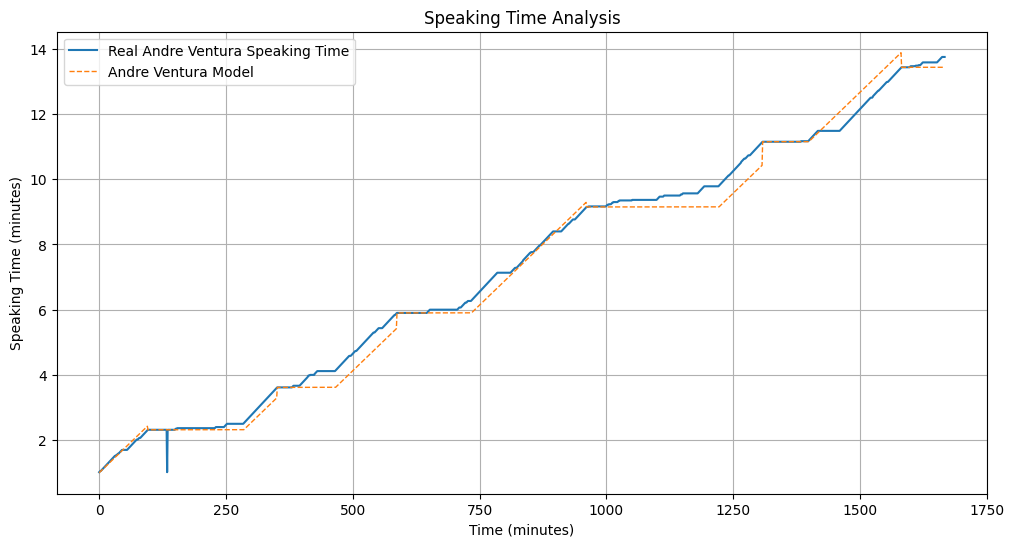

Andre Ventura Mean deviation: 0.10641839195310415


In [16]:

x_values4 = np.array([i for i in range(len(ISR_minutes_filtered))]) #Vai até 2230

segments_ISR = [
    (0, 129, 'c', ISR_minutes_filtered[0]),
    (130, 306, 'l', 0.015),
    (307, 349, 'c', ISR_minutes_filtered[307]),
    (350, 424, 'l', 0.015),
    (425, 593, 'c', ISR_minutes_filtered[425]),
    (594, 746, 'l', 0.015),
    (747, 970, 'c', ISR_minutes_filtered[747]),
    (971, 1188, 'l', 0.015),
    (1189, 1308, 'c', ISR_minutes_filtered[1189]),
    (1309, 1410, 'l', 0.015),
    (1411, 1620, 'c', ISR_minutes_filtered[1411]),
    (1621, 1657, 'l', 0.015),
    (1658, 1667, 'c', ISR_minutes_filtered[1658])
]

segments_AndreVentura = [
    (0, 95, 'l', (0.015, 1)),
    (96, 284, 'c', AndreVentura_minutes_filtered[96]),
    (285, 350, 'l', 0.015),
    (351, 465, 'c', AndreVentura_minutes_filtered[351]),
    (466, 586, 'l', 0.015),
    (587, 733, 'c', AndreVentura_minutes_filtered[587]),
    (734, 960, 'l', 0.015),
    (961, 1221, 'c', AndreVentura_minutes_filtered[961]),
    (1222, 1307, 'l', 0.015),
    (1308, 1398, 'c', AndreVentura_minutes_filtered[1308]),
    (1399, 1581, 'l', 0.015),
    (1582, 1671, 'c', AndreVentura_minutes_filtered[1582])
]

# Compute piecewise functions
x_custom_ISR, y_custom_ISR = calculate_custom_function_affine(segments_ISR)
x_custom_AndreVentura, y_custom_AndreVentura = calculate_custom_function_affine(segments_AndreVentura)

# Equalizing lengths if necessary
if len(x_custom_ISR) > len(x_custom_AndreVentura):
    x_custom_ISR = x_custom_ISR[:len(x_custom_AndreVentura)]
    y_custom_ISR = y_custom_ISR[:len(y_custom_AndreVentura)]

if len(x_custom_AndreVentura) > len(x_custom_ISR):
    x_custom_AndreVentura = x_custom_AndreVentura[:len(x_custom_ISR)]
    y_custom_AndreVentura = y_custom_AndreVentura[:len(y_custom_ISR)]

# Plotting and analysis
plot_and_analyze_speaking_time(x_values4, ISR_minutes_filtered, x_custom_ISR, y_custom_ISR, "ISR")
plot_and_analyze_speaking_time(x_values4, AndreVentura_minutes_filtered, x_custom_AndreVentura, y_custom_AndreVentura, "Andre Ventura")

PCP PAN

In [17]:
# Load the pickle file into a DataFrame
data = pd.read_pickle('pkl_files\\pan-cdu.pkl')

count: 1 data: ['3']
count: 2 data: ['3']
count: 3 data: ['3']
count: 4 data: ['3', '=']
count: 5 data: ['7=3']
count: 6 data: []
count: 7 data: ['2824', 'LEGISLATIVAS']
count: 8 data: ['3', 'DEBA', '2424', 'LEGISLATIVAS']
count: 9 data: ['23', 'DEBATE', '2624', 'LEGISLATIVAS']
count: 10 data: ['3', 'DEBATE', '2024', 'LEGISLATIVAS']
count: 11 data: ['3']
count: 12 data: ['23']
count: 13 data: ['23']
count: 14 data: ['1', '9', '[2624']
count: 15 data: ['0', '9', '{2124']
count: 16 data: ['1', '[2124']
count: 17 data: ['1', 'JUAU AuELINU FaKIA', '6', '9', '2(24']
count: 18 data: ['82624', 'JOÃO ADELINO FARIA', 'RTP']
count: 19 data: ['1', 'JOÃO ADELINO FARIA', '5', 'RTP', '2{24']
count: 20 data: ['[2124']
count: 21 data: ['82624']
count: 22 data: ['82624']
count: 23 data: ['82624']
count: 24 data: ['23', '9', '2624']
count: 25 data: ['=3', '5', '2624']
count: 26 data: ['=3', '8', 'RAAULBO', 'oo:oOloO:OO', 'SOUYÊREAL', '2624']
count: 27 data: ['23', '@', 'RAAULBO', 'oo:oOloO:OO', 'SOUMÊRE

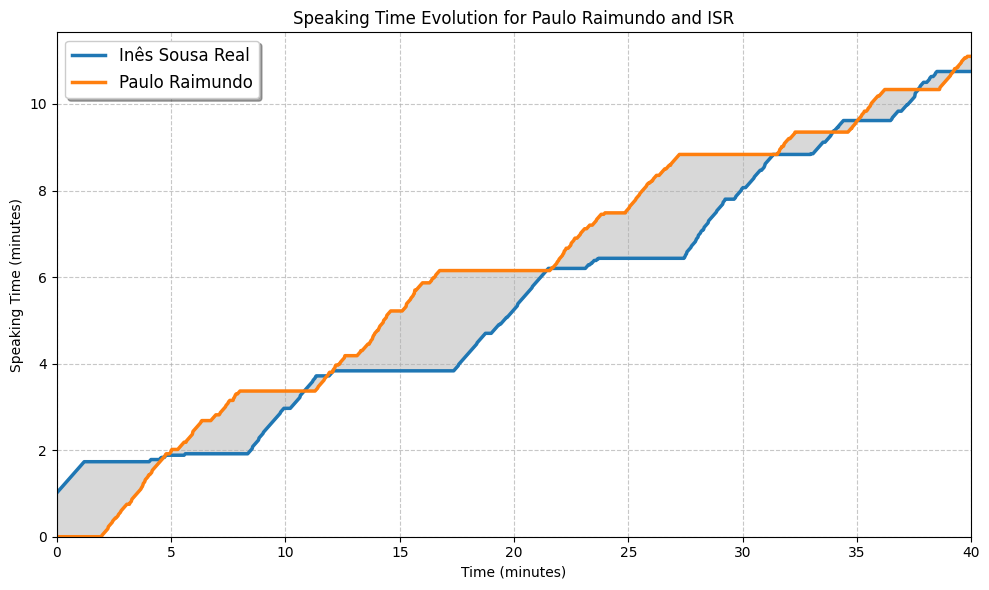

In [18]:

#first lets order the images

data = data.sort_values(by='filename')

count = 0

for i in range(len(data)):
    count = count +1
    print("count: " + str(count) + " data: " + str(data.iloc[i, 4]))

pd.set_option('display.max_rows', None)

pattern_Raimundo= r'\bRA\w+\b'

Used_list = []


# Iterate over the rows of the DataFrame starting from index 73
for i in range(149, len(data)):

    # Extract the list from the specified column
    data_inside = data.iloc[i, 4]

    # Iterate over each string in the list
    for j in range(len(data_inside)):

        # Check if the pattern matches the string
        if re.search(pattern_Raimundo, data_inside[j]):
            

            # If pattern is found, extract the current string and the next three strings
            desired_info = data_inside[j:j+4]  # Extract the next three strings

            translated_info = []
            for item in desired_info:
                if re.match(pattern_Raimundo, item):
                    translated_info.append("Paulo Raimundo")
                elif re.match(pattern_ISR, item):
                    translated_info.append("Inês Sousa Real")
                else:
                    translated_info.append(item)

            # Append the translated_info to Used_list
            Used_list.append(translated_info)


# Filter out lists with exactly 4 objects
Used_list = [desired_info for desired_info in Used_list if len(desired_info) == 4]

print(Used_list)

# Initialize arrays to store Montenegro and Ventura times
Paulo_times = []
ISR1_times = []


for list in Used_list:
 
    # Get the first two characters
    first_part_m = list[1][:2]

    # Get the last two characters
    second_part_m = list[1][-2:]

    first_part_v = list[2][:2]

    second_part_v = list[2][-2:]
    
     # Join the Raimundi parts with a period in the middle
    Paulo_time = f"{first_part_m}.{second_part_m}"

    # Join the ISR parts with a period in the middle
    ISR1_time = f"{first_part_v}.{second_part_v}"
    
    # Append the times to the arrays
    Paulo_times.append(Paulo_time)
    ISR1_times.append(ISR1_time)


ISR1_times = [time.replace('O', '0').replace('I', '1').replace('l', '1') for time in ISR1_times]
Paulo_times = [time.replace('O', '0').replace('I', '1').replace('l', '1') for time in Paulo_times]


ISR1_times_filtered = [time for time in ISR1_times if 'Pa' not in time and 'hu' not in time and '0]' not in time and '@' not in time and 'BE' not in time]
Paulo_times_filtered = [time for time in Paulo_times if 'BE' not in time and 'AN' not in time ]


ISR1_minutes_filtered = [time_str_to_float(time) for time in ISR1_times_filtered]
Paulo_minutes_filtered = [time_str_to_float(time) for time in Paulo_times_filtered]

####################################### Plot the Filtered Data with Outliers Removed  #######################################

total_debate_time = 40  # Assuming the total time for the debate in minutes
total_speech_turns = max(len(ISR1_minutes_filtered), len(Paulo_minutes_filtered))

# Calculate the average duration per speech turn in minutes, if you have a total count of turns
average_duration_per_turn = total_debate_time / total_speech_turns

# Generate x-axis values corresponding to the actual time in minutes
x_axis_time = [i * average_duration_per_turn for i in range(total_speech_turns)]

'''for i in range(0, len(ISR_minutes_filtered)):
    if ISR_minutes_filtered[i] == 82.4 or ISR_minutes_filtered[i] == 1.0166666666666666:
        ISR_minutes_filtered[i] = ISR_minutes_filtered[i-1]'''
        
plt.figure(figsize=(10, 6))  # Specify the figure size for better visibility

# Use the generated x-axis for both speakers to show actual time distribution across the debate
plt.plot(x_axis_time[:len(ISR1_minutes_filtered)], ISR1_minutes_filtered, label='Inês Sousa Real', linewidth=2.5)
plt.plot(x_axis_time[:len(Paulo_minutes_filtered)], Paulo_minutes_filtered, label='Paulo Raimundo', linewidth=2.5)

plt.fill_between(x_axis_time[:min(len(ISR1_minutes_filtered), len(Paulo_minutes_filtered))], 
                  ISR1_minutes_filtered[:min(len(ISR1_minutes_filtered), len(Paulo_minutes_filtered))], 
                  Paulo_minutes_filtered[:min(len(ISR1_minutes_filtered), len(Paulo_minutes_filtered))], color='grey', alpha=0.3)

plt.xlabel('Time (minutes)')
plt.ylabel('Speaking Time (minutes)')
plt.title('Speaking Time Evolution for Paulo Raimundo and ISR')

plt.legend(loc='upper left', fontsize='large', frameon=True, shadow=True)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(left=0, right=total_debate_time) 
plt.ylim(bottom=0)  

plt.tight_layout() 
plt.show()


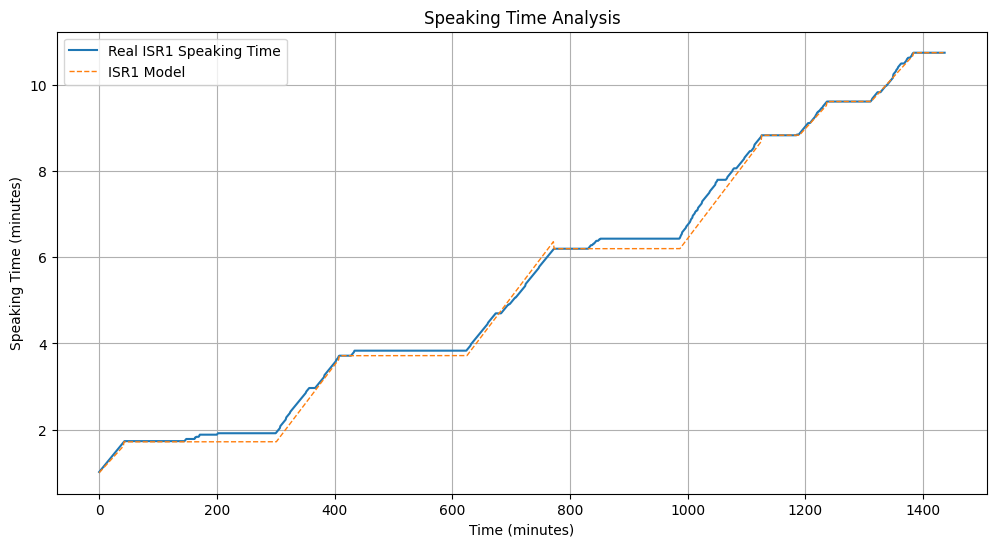

ISR1 Mean deviation: 0.023596822747643315


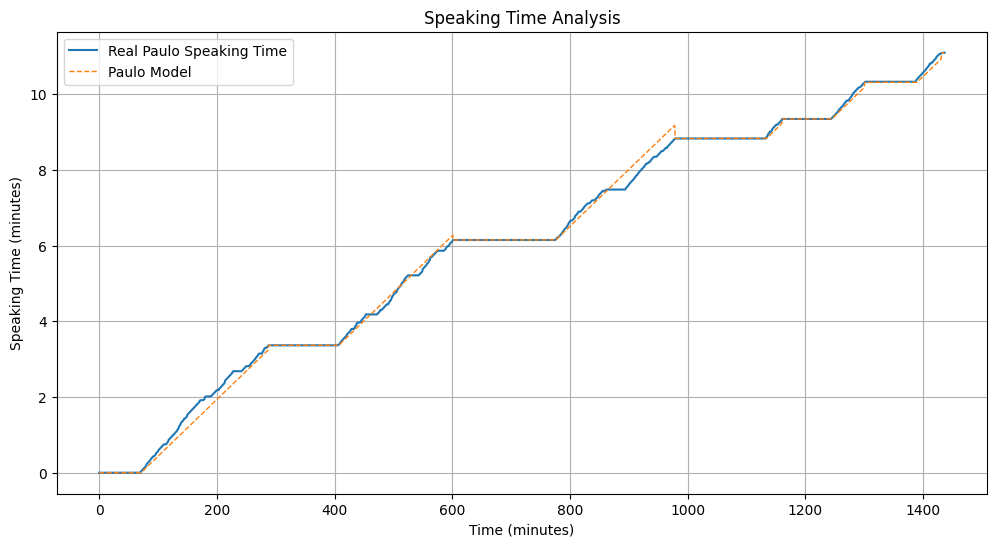

Paulo Mean deviation: 0.019783047442435496


In [19]:

x_values5 = np.array([i for i in range(len(Paulo_minutes_filtered))]) #Vai até 2230


segments_ISR1 = [
    (0, 41, 'l', (0.015, 1)),
    (42, 300, 'c', ISR1_minutes_filtered[42]),
    (301, 407, 'l', 0.018),
    (408, 624, 'c', ISR1_minutes_filtered[408]),
    (625, 772, 'l', 0.018),
    (773, 986, 'c', ISR1_minutes_filtered[773]),
    (987, 1125, 'l', 0.018),
    (1126, 1189, 'c', ISR1_minutes_filtered[1126]),
    (1190, 1236, 'l', 0.015),
    (1237, 1311, 'c', ISR1_minutes_filtered[1237]),
    (1312, 1383, 'l', 0.015),
    (1384, 1437, 'c', ISR1_minutes_filtered[1384])
]

segments_Paulo = [
    (0, 70, 'c', Paulo_minutes_filtered[0]),
    (71, 287, 'l', 0.015),
    (288, 406, 'c', Paulo_minutes_filtered[288]),
    (407, 601, 'l', 0.015),
    (602, 775, 'c', Paulo_minutes_filtered[602]),
    (776, 978, 'l', 0.015),
    (979, 1133, 'c', Paulo_minutes_filtered[979]),
    (1134, 1160, 'l', 0.015),
    (1161, 1244, 'c', Paulo_minutes_filtered[1161]),
    (1245, 1300, 'l', 0.015),
    (1301, 1389, 'c', Paulo_minutes_filtered[1301]),
    (1390, 1431, 'l', 0.015),
    (1432, 1436, 'c', Paulo_minutes_filtered[1432])
]

# Compute piecewise functions
x_custom_ISR1, y_custom_ISR1 = calculate_custom_function_affine(segments_ISR1)
x_custom_Paulo, y_custom_Paulo = calculate_custom_function_affine(segments_Paulo)

# Equalizing lengths if necessary
if len(x_custom_ISR1) > len(x_custom_Paulo):
    x_custom_ISR1 = x_custom_ISR1[:len(x_custom_Paulo)]
    y_custom_ISR1 = y_custom_ISR1[:len(y_custom_Paulo)]

if len(x_custom_Paulo) > len(x_custom_ISR1):
    x_custom_Paulo = x_custom_Paulo[:len(x_custom_ISR1)]
    y_custom_Paulo = y_custom_Paulo[:len(y_custom_ISR1)]

# Plotting and analysis
plot_and_analyze_speaking_time(x_values5, ISR1_minutes_filtered, x_custom_ISR1, y_custom_ISR1, "ISR1")
plot_and_analyze_speaking_time(x_values5, Paulo_minutes_filtered, x_custom_Paulo, y_custom_Paulo, "Paulo")


CDU VS AD

In [20]:
# Load the pickle file into a DataFrame
data = pd.read_pickle('pkl_files\\ad-cdu.pkl')

count: 1 data: ['Hl;', "'=3", 'U']
count: 2 data: ['H7G', 'VA', '=3']
count: 3 data: ['3']
count: 4 data: ['3']
count: 5 data: ['73']
count: 6 data: ['23', 'AP']
count: 7 data: ['=3', 'AP', '2124', 'LEGISLATIVAS']
count: 8 data: ['3', 'AP', 'DEE', '2424', 'LEGISLATIVAS']
count: 9 data: ['3', 'DEBATE', '2424', 'LEGISLATIVAS']
count: 10 data: ['3', 'DEBATE', 'LEGISLATIVAS', '2024']
count: 11 data: ['n']
count: 12 data: ['23', '9', 'EsuTAS', 'ª', '9', '[2524']
count: 13 data: ['3', '2624', 'Cslatwas', '77', 'ª', '9', '2924']
count: 14 data: ['lat', 'FSLAÍ', '6', '6', 'I', '9', '[2524']
count: 15 data: ['212', 'FsLAT', 'i', 'I', '9', '72624', 'n']
count: 16 data: ['22', 'F', 'FsLAT', '1', 'i', '1', '9', '2624', '14, ,']
count: 17 data: ['FsLAT', '0', '1', '9', '42(', '811', '2924']
count: 18 data: ['ESLATI', 'G', 'JOÃO ADELINO FARIA', 'RTP', '424', 'Ya']
count: 19 data: ['74,d', 'FsLATs', 'i', 'JOÃO ADELINO FARIA', 'RTP', '424']
count: 20 data: ['ESLATI', 'G', '42']
count: 21 data: ['FSLAT

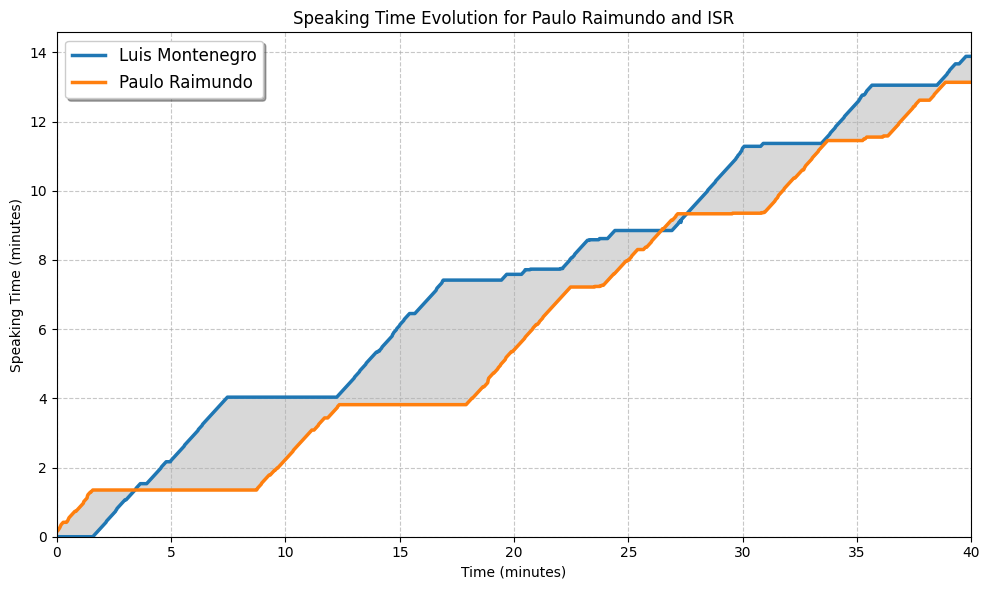

In [21]:

#first lets order the images

data = data.sort_values(by='filename')

count = 0

for i in range(len(data)):
    count = count +1
    print("count: " + str(count) + " data: " + str(data.iloc[i, 4]))

pd.set_option('display.max_rows', None)

Used_list = []


# Iterate over the rows of the DataFrame starting from index 73
for i in range(78, len(data)):

    # Extract the list from the specified column
    data_inside = data.iloc[i, 4]

    # Iterate over each string in the list
    for j in range(len(data_inside)):

        # Check if the pattern matches the string
        if re.search(pattern_Raimundo, data_inside[j]):
            

            # If pattern is found, extract the current string and the next three strings
            desired_info = data_inside[j:j+4]  # Extract the next three strings

            translated_info = []
            for item in desired_info:
                if re.match(pattern_Raimundo, item):
                    translated_info.append("Paulo Raimundo")
                elif re.match(pattern_m, item):
                    translated_info.append("Luis Montenegro")
                else:
                    translated_info.append(item)

            # Append the translated_info to Used_list
            Used_list.append(translated_info)


# Filter out lists with exactly 4 objects
Used_list = [desired_info for desired_info in Used_list if len(desired_info) == 4]

print(Used_list)

# Initialize arrays to store Montenegro and Ventura times
Paulo1_times = []
Montenegro2_times = []


for list in Used_list:
 
    # Get the first two characters
    first_part_m = list[1][:2]

    # Get the last two characters
    second_part_m = list[1][-2:]

    first_part_v = list[2][:2]

    second_part_v = list[2][-2:]

    Paulo1_time = f"{first_part_m}.{second_part_m}"

    Montenegro2_time = f"{first_part_v}.{second_part_v}"
    
    # Append the times to the arrays
    Paulo1_times.append(Paulo1_time)
    Montenegro2_times.append(Montenegro2_time)


Paulo1_times = [time.replace('O', '0').replace('I', '1').replace('l', '1') for time in Paulo1_times]
Montenegro2_times = [time.replace('O', '0').replace('I', '1').replace('l', '1') for time in Montenegro2_times]


Montenegro2_times_filtered = [time for time in Montenegro2_times if 'Ro' not in time and 'R0' not in time and '{2' not in time and 'CD' not in time and 'CD' not in time]
Paulo1_times_filtered = [time for time in Paulo1_times if 'CD' not in time and 'AN' not in time ]

Montenegro2_minutes_filtered = [time_str_to_float(time) for time in Montenegro2_times_filtered]
Paulo1_minutes_filtered = [time_str_to_float(time) for time in Paulo1_times_filtered]

Paulo1_minutes_filtered = Paulo1_minutes_filtered[:len(Montenegro2_minutes_filtered)]

####################################### Plot the Filtered Data with Outliers Removed  #######################################

total_debate_time = 40  # Assuming the total time for the debate in minutes
total_speech_turns = max(len(Montenegro2_minutes_filtered), len(Paulo1_minutes_filtered))

# Calculate the average duration per speech turn in minutes, if you have a total count of turns
average_duration_per_turn = total_debate_time / total_speech_turns

# Generate x-axis values corresponding to the actual time in minutes
x_axis_time = [i * average_duration_per_turn for i in range(total_speech_turns)]

for i in range(0, len(Montenegro2_minutes_filtered)):
    if Montenegro2_minutes_filtered[i] == 82.4 or Montenegro2_minutes_filtered[i] == 9.15:
        Montenegro2_minutes_filtered[i] = Montenegro2_minutes_filtered[i-4]
       
plt.figure(figsize=(10, 6))  # Specify the figure size for better visibility

# Use the generated x-axis for both speakers to show actual time distribution across the debate
plt.plot(x_axis_time[:len(Montenegro2_minutes_filtered)], Montenegro2_minutes_filtered, label='Luis Montenegro', linewidth=2.5)
plt.plot(x_axis_time[:len(Paulo1_minutes_filtered)], Paulo1_minutes_filtered, label='Paulo Raimundo', linewidth=2.5)

plt.fill_between(x_axis_time[:min(len(Montenegro2_minutes_filtered), len(Paulo1_minutes_filtered))], 
                 Montenegro2_minutes_filtered[:min(len(Montenegro2_minutes_filtered), len(Paulo1_minutes_filtered))], 
                  Paulo1_minutes_filtered[:min(len(Montenegro2_minutes_filtered), len(Paulo1_minutes_filtered))], color='grey', alpha=0.3)

# Add labels and title with more description
plt.xlabel('Time (minutes)')
plt.ylabel('Speaking Time (minutes)')
plt.title('Speaking Time Evolution for Paulo Raimundo and ISR')

# Enhance the legend
plt.legend(loc='upper left', fontsize='large', frameon=True, shadow=True)

# Show the plot with an enhanced grid for better readability and axis range adjustment
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(left=0, right=total_debate_time)  # Adjust x-axis to cover the total debate duration
plt.ylim(bottom=0)  # Start y-axis at zero

plt.tight_layout()  # Adjust layout to fit elements neatly
plt.show()



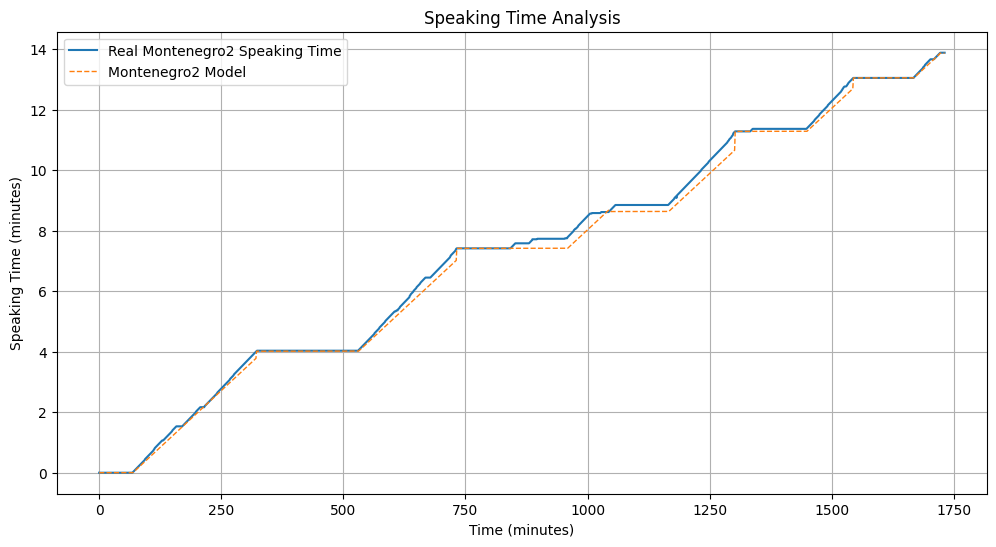

Montenegro2 Mean deviation: 0.03805328618167825


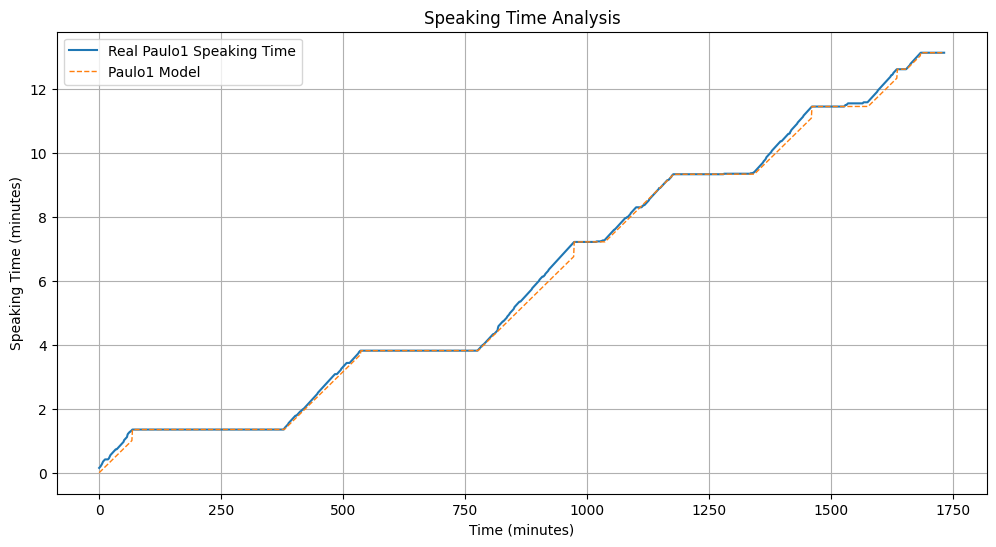

Paulo1 Mean deviation: 0.017606124903772148


In [22]:

x_values6 = np.array([i for i in range(len(Montenegro2_minutes_filtered))]) #Vai até 2230


segments_Montenegro2 = [
    (0, 68, 'c', Montenegro2_minutes_filtered[0]),
    (69, 321, 'l', 0.015),
    (322, 530, 'c', Montenegro2_minutes_filtered[322]),
    (531, 731, 'l', 0.015),
    (732, 958, 'c', Montenegro2_minutes_filtered[732]),
    (959, 1043, 'l', 0.015),
    (1044, 1165, 'c', Montenegro2_minutes_filtered[1044]),
    (1166, 1301, 'l', 0.015),
    (1302, 1448, 'c', Montenegro2_minutes_filtered[1302]),
    (1449, 1543, 'l', 0.015),
    (1544, 1667, 'c', Montenegro2_minutes_filtered[1544]),
    (1668, 1720, 'l', 0.015),
    (1721, 1731, 'c', Montenegro2_minutes_filtered[1721])
]

segments_Paulo1 = [
    (0, 67, 'l', 0.015),
    (68, 378, 'c', Paulo1_minutes_filtered[68]),
    (379, 535, 'l', 0.015),
    (536, 775, 'c', Paulo1_minutes_filtered[536]),
    (776, 972, 'l', 0.015),
    (973, 1035, 'c', Paulo1_minutes_filtered[973]),
    (1036, 1175, 'l', 0.015),
    (1176, 1341, 'c', Paulo1_minutes_filtered[1176]),
    (1342, 1459, 'l', 0.015),
    (1460, 1574, 'c', Paulo1_minutes_filtered[1460]),
    (1575, 1634, 'l', 0.015),
    (1635, 1653, 'c', Paulo1_minutes_filtered[1635]),
    (1654, 1682, 'l', 0.015),
    (1683, 1759, 'c', Paulo1_minutes_filtered[1683])
]

# Compute piecewise functions
x_custom_Montenegro2, y_custom_Montenegro2 = calculate_custom_function_affine(segments_Montenegro2)
x_custom_Paulo1, y_custom_Paulo1 = calculate_custom_function_affine(segments_Paulo1)

# Ensure equal lengths for plotting
if len(x_custom_Montenegro2) > len(x_custom_Paulo1):
    x_custom_Montenegro2 = x_custom_Montenegro2[:len(x_custom_Paulo1)]
    y_custom_Montenegro2 = y_custom_Montenegro2[:len(y_custom_Paulo1)]

if len(x_custom_Paulo1) > len(x_custom_Montenegro2):
    x_custom_Paulo1 = x_custom_Paulo1[:len(x_custom_Montenegro2)]
    y_custom_Paulo1 = y_custom_Paulo1[:len(y_custom_Montenegro2)]

# Plotting and analysis
plot_and_analyze_speaking_time(x_values6, Montenegro2_minutes_filtered, x_custom_Montenegro2, y_custom_Montenegro2, "Montenegro2")
plot_and_analyze_speaking_time(x_values6, Paulo1_minutes_filtered, x_custom_Paulo1, y_custom_Paulo1, "Paulo1")


LIVRE VS PAN

In [23]:
# Load the pickle file into a DataFrame
data = pd.read_pickle('pkl_files\\pan-livre.pkl')

count: 1 data: ['1', '9', '2624']
count: 2 data: ['1', '9', '2(24']
count: 3 data: ['0', '9', '2624']
count: 4 data: ['0', '9', '2624']
count: 5 data: ['23', '1', '9', '2924']
count: 6 data: ['23', 'AP', 'ª', '2924']
count: 7 data: ['73', 'AP', '[2924', 'TARHRES', 'OO:OOlOO:OO', 'sonSSPEAL']
count: 8 data: ['=3', 'AP', '[2924', 'TARHRES', 'OO:OOlOO:Oo', 'soNSS BEAL']
count: 9 data: ['23', '[2924', 'TARYRES', 'OO:OOlOO:Oo', 'soNSS REAL']
count: 10 data: ['=3', '[2924', 'TARYRES', 'OO:OOlOO:OO', 'sonSSPEAL']
count: 11 data: ['23', '82624', 'TARYRES', 'OO:OOIOO:OO', 'sonSSPEAL', '9']
count: 12 data: ['23', '[2924', 'TARHRES', 'OO:oOIoO:OO', 'sonSSPEAL']
count: 13 data: ['23', '1', 'TARYRES', 'OO:OOIOO:OO', 'sonSSPEAL', '9', '2624']
count: 14 data: ['=3', '[2924', 'TARYRES', 'OO:OOlOO:OO', 'sonSSPEAL', '9']
count: 15 data: ['3', '[2924', 'TARHRES', 'OO:OOIOO:OO', 'soNSSPEAL', '9']
count: 16 data: ['1', 'TARHRES', 'OO:OOOO:OO', 'soNSSPEAL', '2624']
count: 17 data: ['1', '[2124', 'TARHRES', 

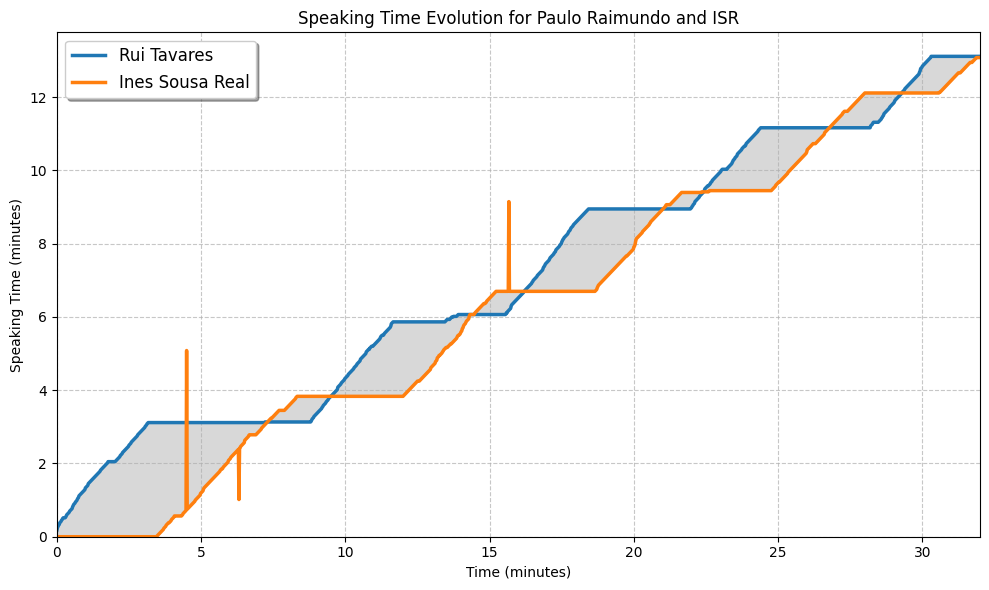

In [24]:

#first lets order the images

data = data.sort_values(by='filename')

count = 0

for i in range(len(data)):
    count = count +1
    print("count: " + str(count) + " data: " + str(data.iloc[i, 4]))

pd.set_option('display.max_rows', None)

Used_list = []

pattern_ISR2= r'\bso\w+\b'


# Iterate over the rows of the DataFrame starting from index 73
for i in range(56, len(data)):

    # Extract the list from the specified column
    data_inside = data.iloc[i, 4]

    # Iterate over each string in the list
    for j in range(len(data_inside)):

        # Check if the pattern matches the string
        if re.search(pattern_T, data_inside[j]):
            

            # If pattern is found, extract the current string and the next three strings
            desired_info = data_inside[j:j+4]  # Extract the next three strings

            translated_info = []
            for item in desired_info:
                if re.match(pattern_T, item):
                    translated_info.append("Rui Tavares")
                elif re.match(pattern_ISR2, item) or re.match(pattern_ISR, item):
                    translated_info.append("Inês Sousa Real")
                else:
                    translated_info.append(item)

            # Append the translated_info to Used_list
            Used_list.append(translated_info)


# Filter out lists with exactly 4 objects
Used_list = [desired_info for desired_info in Used_list if len(desired_info) == 4]

# Initialize arrays to store Montenegro and Ventura times
ISR2_times = []
Tavares_times = []


for list in Used_list:
 
    # Get the first two characters
    first_part_m = list[1][:2]

    # Get the last two characters
    second_part_m = list[1][-2:]

    first_part_v = list[2][:2]

    second_part_v = list[2][-2:]
    
     # Join the PNS parts with a period in the middle
    Tavares_time = f"{first_part_m}.{second_part_m}"

    # Join the Mortagua parts with a period in the middle
    ISR2_time = f"{first_part_v}.{second_part_v}"
    
    # Append the times to the arrays
    Tavares_times.append(Tavares_time)
    ISR2_times.append(ISR2_time)


Tavares_times = [time.replace('O', '0').replace('I', '1').replace('l', '1') for time in Tavares_times]
ISR2_times = [time.replace('O', '0').replace('I', '1').replace('l', '1') for time in ISR2_times]


Tavares_times_filtered = [time for time in Tavares_times if 'Li' not in time and '1n' not in time and '[2' not in time and 'CD' not in time and 'CD' not in time]
ISR2_times_filtered = [time for time in ISR2_times if '[2' not in time and '{2' not in time and 'ª' not in time and '1n' not in time and '|' not in time and 'n' not in time and 'Ae' not in time and '@' not in time and '#' not in time and 'AN' not in time]

Tavares_minutes_filtered = [time_str_to_float(time) for time in Tavares_times_filtered]
ISR2_minutes_filtered = [time_str_to_float(time) for time in ISR2_times_filtered]

####################################### Plot the Filtered Data with Outliers Removed  #######################################

total_debate_time = 32  # Assuming the total time for the debate in minutes
total_speech_turns = max(len(Tavares_minutes_filtered), len(ISR2_minutes_filtered))

# Calculate the average duration per speech turn in minutes, if you have a total count of turns
average_duration_per_turn = total_debate_time / total_speech_turns

# Generate x-axis values corresponding to the actual time in minutes
x_axis_time = [i * average_duration_per_turn for i in range(total_speech_turns)]


plt.figure(figsize=(10, 6))  

ISR2_minutes_filtered=ISR2_minutes_filtered[:len(Tavares_minutes_filtered)]

# Use the generated x-axis for both speakers to show actual time distribution across the debate
plt.plot(x_axis_time[:len(Tavares_minutes_filtered)], Tavares_minutes_filtered, label='Rui Tavares', linewidth=2.5)
plt.plot(x_axis_time[:len(ISR2_minutes_filtered)], ISR2_minutes_filtered, label='Ines Sousa Real', linewidth=2.5)

plt.fill_between(x_axis_time[:min(len(Tavares_minutes_filtered), len(ISR2_minutes_filtered))], 
                 Tavares_minutes_filtered[:min(len(Tavares_minutes_filtered), len(ISR2_minutes_filtered))], 
                  ISR2_minutes_filtered[:min(len(Tavares_minutes_filtered), len(ISR2_minutes_filtered))], color='grey', alpha=0.3)

plt.xlabel('Time (minutes)')
plt.ylabel('Speaking Time (minutes)')
plt.title('Speaking Time Evolution for Paulo Raimundo and ISR')

plt.legend(loc='upper left', fontsize='large', frameon=True, shadow=True)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(left=0, right=total_debate_time)  # Adjust x-axis to cover the total debate duration
plt.ylim(bottom=0)  # Start y-axis at zero

plt.tight_layout()  # Adjust layout to fit elements neatly
plt.show()


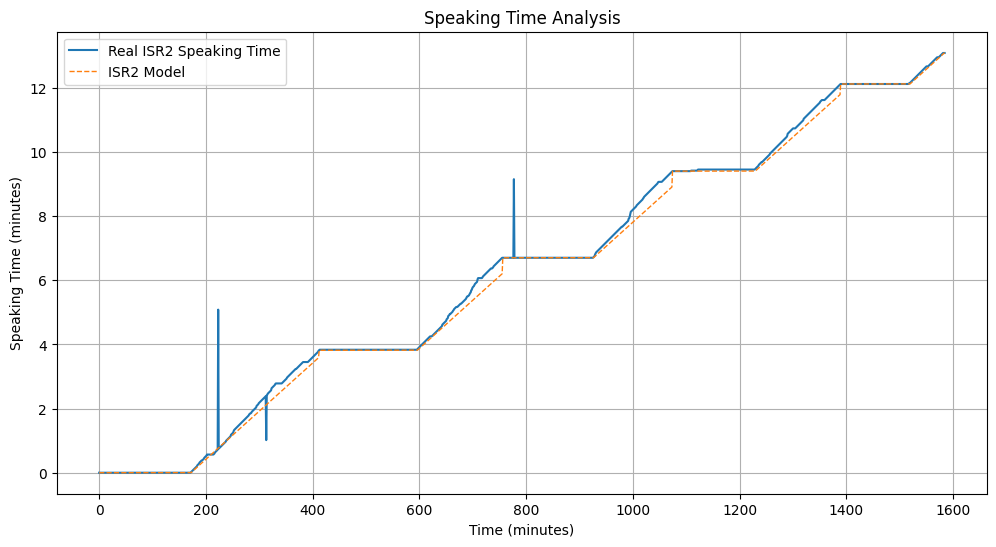

ISR2 Mean deviation: 0.04976122502628811


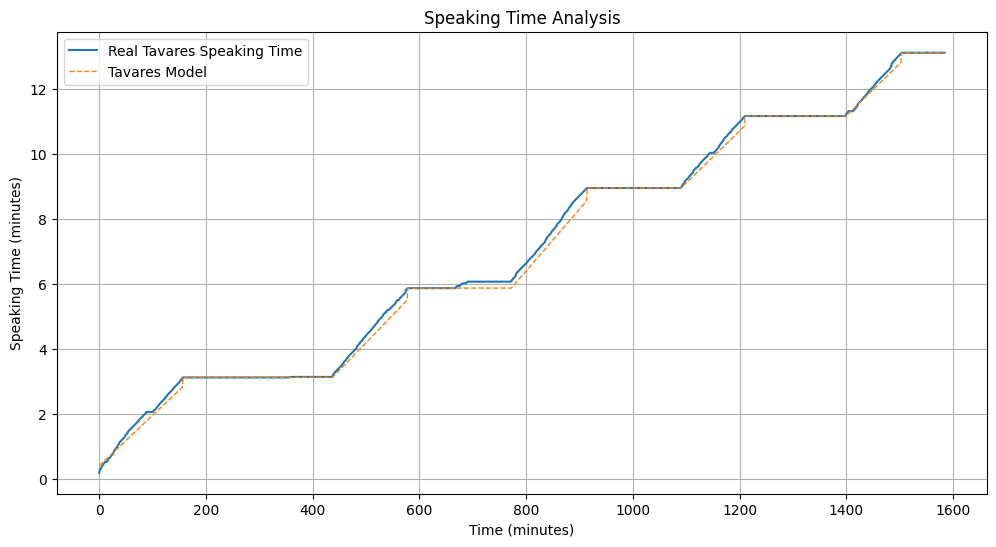

Tavares Mean deviation: 0.023271886680686978


In [25]:
x_values7 = np.array([i for i in range(len(Tavares_minutes_filtered))]) #Vai até 2230

segments_ISR2 = [
    (0, 171, 'c', ISR2_minutes_filtered[0]),
    (172, 411, 'l', 0.015),
    (412, 595, 'c', ISR2_minutes_filtered[412]),
    (596, 755, 'l', 0.015),
    (756, 925, 'c', ISR2_minutes_filtered[756]),
    (926, 1073, 'l', 0.015),
    (1074, 1228, 'c', ISR2_minutes_filtered[1074]),
    (1229, 1388, 'l', 0.015),
    (1389, 1518, 'c', ISR2_minutes_filtered[1389]),
    (1519, 1584, 'l', 0.015)
]

segments_Tavares = [
    (0, 156, 'l', (0.0155,0.4)),
    (157, 436, 'c', Tavares_minutes_filtered[157]),
    (437, 577, 'l', 0.017),
    (578, 771, 'c', Tavares_minutes_filtered[578]),
    (772, 913, 'l', 0.019),
    (914, 1089, 'c', Tavares_minutes_filtered[914]),
    (1090, 1209, 'l', 0.016),
    (1210, 1398, 'c', Tavares_minutes_filtered[1210]),
    (1399, 1502, 'l', 0.016),
    (1503, 1584, 'c', Tavares_minutes_filtered[1503])
]

# Compute piecewise functions
x_custom_ISR2, y_custom_ISR2 = calculate_custom_function_affine(segments_ISR2)
x_custom_Tavares, y_custom_Tavares = calculate_custom_function_affine(segments_Tavares)

# Ensure equal lengths for plotting if necessary
if len(x_custom_ISR2) > len(x_custom_Tavares):
    x_custom_ISR2 = x_custom_ISR2[:len(x_custom_Tavares)]
    y_custom_ISR2 = y_custom_ISR2[:len(y_custom_Tavares)]

if len(x_custom_Tavares) > len(x_custom_ISR2):
    x_custom_Tavares = x_custom_Tavares[:len(x_custom_ISR2)]
    y_custom_Tavares = y_custom_Tavares[:len(y_custom_ISR2)]

# Plotting and analysis
plot_and_analyze_speaking_time(x_values7, ISR2_minutes_filtered, x_custom_ISR2, y_custom_ISR2, "ISR2")
plot_and_analyze_speaking_time(x_values7, Tavares_minutes_filtered, x_custom_Tavares, y_custom_Tavares, "Tavares")



IL CDU

In [26]:
# Load the pickle file into a DataFrame
data = pd.read_pickle('pkl_files\\il-cdu.pkl')

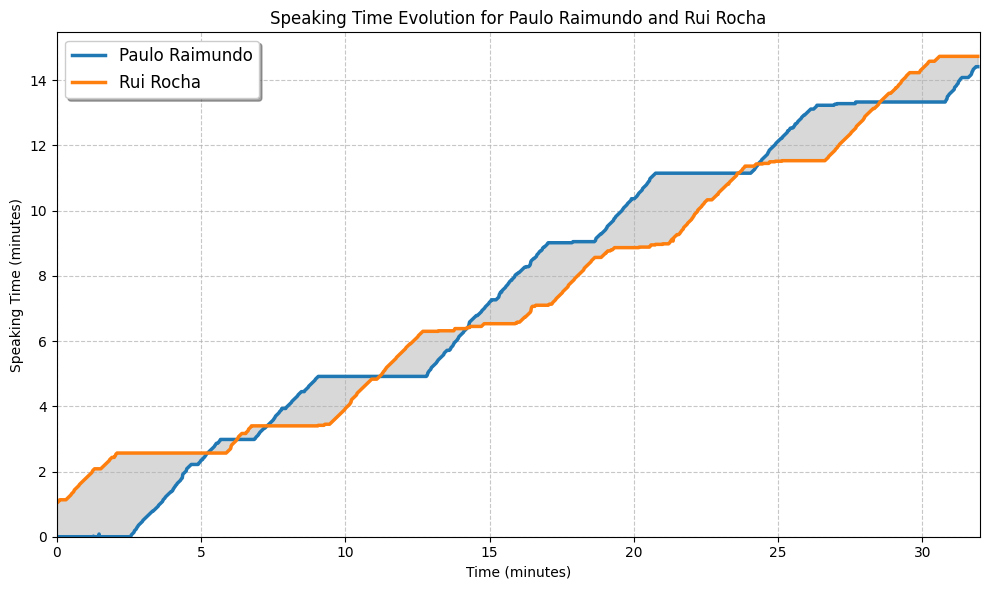

In [27]:

#first lets order the images

data = data.sort_values(by='filename')

count = 0

pd.set_option('display.max_rows', None)

Used_list = []

pattern_Rocha= r'\bR\w+\b'


# Iterate over the rows of the DataFrame starting from index 73
for i in range(115, len(data)):

    # Extract the list from the specified column
    data_inside = data.iloc[i, 4]

    # Iterate over each string in the list
    for j in range(len(data_inside)):

        # Check if the pattern matches the string
        if re.search(pattern_Raimundo, data_inside[j]):
            

            # If pattern is found, extract the current string and the next three strings
            desired_info = data_inside[j:j+4]  # Extract the next three strings

            translated_info = []
            for item in desired_info:
                if re.match(pattern_Raimundo, item):
                    translated_info.append("Paulo Raimundo")
                elif re.match(pattern_Rocha, item):
                    translated_info.append("Rui Rocha")
                else:
                    translated_info.append(item)

            # Append the translated_info to Used_list
            Used_list.append(translated_info)


# Filter out lists with exactly 4 objects
Used_list = [desired_info for desired_info in Used_list if len(desired_info) == 4]


# Initialize arrays to store Montenegro and Ventura times
Paulo2_times = []
RuiRocha_times = []


for list in Used_list:
 
    # Get the first two characters
    first_part_m = list[1][:2]

    # Get the last two characters
    second_part_m = list[1][-2:]

    first_part_v = list[2][:2]

    second_part_v = list[2][-2:]
    
     # Join the PNS parts with a period in the middle
    Paulo2_time = f"{first_part_m}.{second_part_m}"

    # Join the Mortagua parts with a period in the middle
    RuiRocha_time = f"{first_part_v}.{second_part_v}"
    
    # Append the times to the arrays
    Paulo2_times.append(Paulo2_time)
    RuiRocha_times.append(RuiRocha_time)


Paulo2_times = [time.replace('O', '0').replace('I', '1').replace('l', '1') for time in Paulo2_times]
RuiRocha_times = [time.replace('O', '0').replace('I', '1').replace('l', '1') for time in RuiRocha_times]


Paulo2_times_filtered = [time for time in Paulo2_times if 'Ru' not in time and '1n' not in time and '[2' not in time and 'CD' not in time and 'CD' not in time]
RuiRocha_times_filtered = [time for time in RuiRocha_times if 'Ru' not in time and '{2' not in time and 'ª' not in time and '1n' not in time and '|' not in time and 'n' not in time and 'Ae' not in time and '@' not in time and '#' not in time and 'AN' not in time]

Paulo2_minutes_filtered = [time_str_to_float(time) for time in Paulo2_times_filtered]
RuiRocha_minutes_filtered = [time_str_to_float(time) for time in RuiRocha_times_filtered]


total_debate_time = 32  # Assuming the total time for the debate in minutes
total_speech_turns = max(len(Paulo2_minutes_filtered), len(RuiRocha_minutes_filtered))

# Calculate the average duration per speech turn in minutes, if you have a total count of turns
average_duration_per_turn = total_debate_time / total_speech_turns

# Generate x-axis values corresponding to the actual time in minutes
x_axis_time = [i * average_duration_per_turn for i in range(total_speech_turns)]

for i in range(0, len(RuiRocha_minutes_filtered)):
    if RuiRocha_minutes_filtered[i] == 82.4 or RuiRocha_minutes_filtered[i] == 9.15 or RuiRocha_minutes_filtered[i] == 1.0166666666666666:
        RuiRocha_minutes_filtered[i] = RuiRocha_minutes_filtered[i-4]
       

RuiRocha_minutes_filtered = RuiRocha_minutes_filtered[1:len(Paulo2_minutes_filtered)]

Paulo2_minutes_filtered = Paulo2_minutes_filtered[:len(RuiRocha_minutes_filtered)]

plt.figure(figsize=(10, 6))  # Specify the figure size for better visibility

'''Rui_minutes_filtered=ISR2_minutes_filtered[:len(Tavares_minutes_filtered)]'''

# Use the generated x-axis for both speakers to show actual time distribution across the debate
plt.plot(x_axis_time[:len(Paulo2_minutes_filtered)], Paulo2_minutes_filtered, label='Paulo Raimundo', linewidth=2.5)
plt.plot(x_axis_time[:len(RuiRocha_minutes_filtered)], RuiRocha_minutes_filtered, label='Rui Rocha', linewidth=2.5)

plt.fill_between(x_axis_time[:min(len(Paulo2_minutes_filtered), len(RuiRocha_minutes_filtered))], 
                 Paulo2_minutes_filtered[:min(len(Paulo2_minutes_filtered), len(RuiRocha_minutes_filtered))], 
                  RuiRocha_minutes_filtered[:min(len(Paulo2_minutes_filtered), len(RuiRocha_minutes_filtered))], color='grey', alpha=0.3)

# Add labels and title with more description
plt.xlabel('Time (minutes)')
plt.ylabel('Speaking Time (minutes)')
plt.title('Speaking Time Evolution for Paulo Raimundo and Rui Rocha')

# Enhance the legend
plt.legend(loc='upper left', fontsize='large', frameon=True, shadow=True)

# Show the plot with an enhanced grid for better readability and axis range adjustment
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(left=0, right=total_debate_time)  # Adjust x-axis to cover the total debate duration
plt.ylim(bottom=0)  # Start y-axis at zero

plt.tight_layout()  # Adjust layout to fit elements neatly
plt.show()


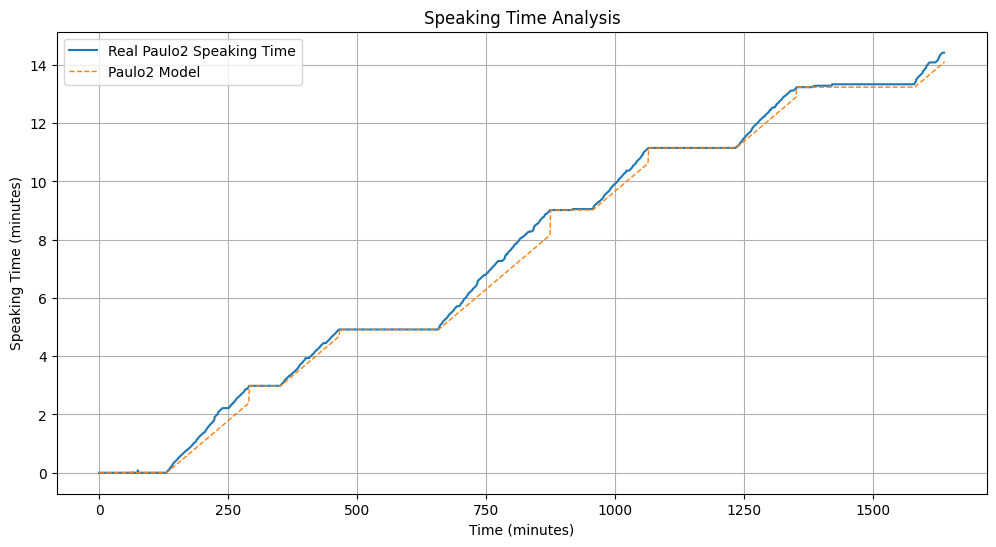

Paulo2 Mean deviation: 0.07410407091044674


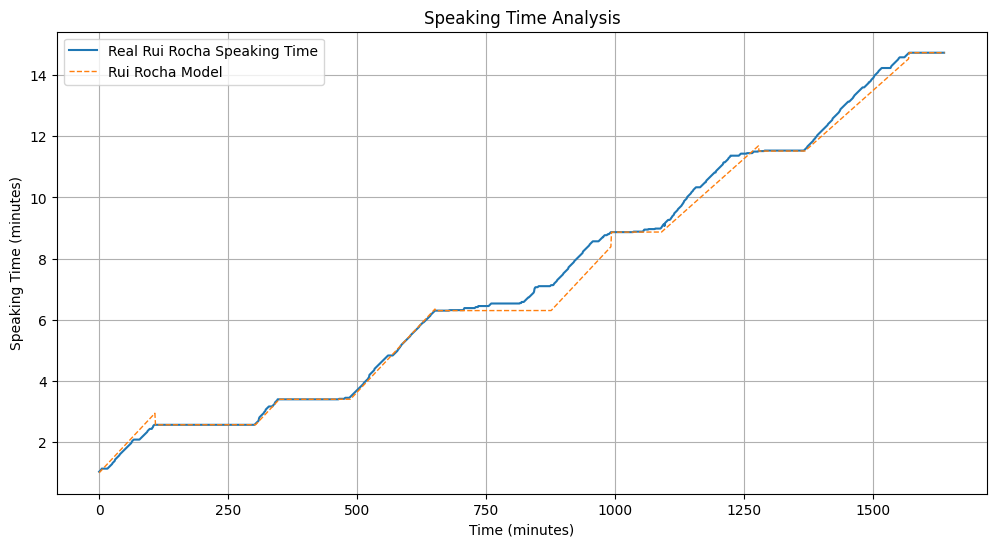

Rui Rocha Mean deviation: 0.08505731536844954


In [28]:
x_values8 = np.array([i for i in range(len(RuiRocha_minutes_filtered))]) #Vai até 2230


segments_Paulo2 = [
    (0, 130, 'c', Paulo2_minutes_filtered[0]),
    (131, 290, 'l', 0.015),
    (291, 351, 'c', Paulo2_minutes_filtered[291]),
    (352, 465, 'l', 0.015),
    (466, 657, 'c', Paulo2_minutes_filtered[466]),
    (658, 874, 'l', 0.015),
    (875, 956, 'c', Paulo2_minutes_filtered[875]),
    (957, 1064, 'l', 0.015),
    (1065, 1234, 'c', Paulo2_minutes_filtered[1065]),
    (1235, 1351, 'l', 0.015),
    (1352, 1580, 'c', Paulo2_minutes_filtered[1352]),
    (1581, 1639, 'l', 0.015)
]

segments_RuiRocha = [
    (0, 108, 'l', (0.018, 1)),
    (109, 302, 'c', RuiRocha_minutes_filtered[109]),
    (303, 346, 'l', 0.018),
    (347, 486, 'c', RuiRocha_minutes_filtered[347]),
    (487, 651, 'l', 0.018),
    (652, 875, 'c', RuiRocha_minutes_filtered[652]),
    (876, 992, 'l', 0.018),
    (993, 1089, 'c', RuiRocha_minutes_filtered[993]),
    (1090, 1278, 'l', 0.015),
    (1279, 1367, 'c', RuiRocha_minutes_filtered[1279]),
    (1368, 1569, 'l', 0.015),  # Adjusted overlapping range from 1352 to 1368
    (1570, 1641, 'c', RuiRocha_minutes_filtered[1570])
]

# Compute piecewise functions
x_custom_Paulo2, y_custom_Paulo2 = calculate_custom_function_affine(segments_Paulo2)
x_custom_RuiRocha, y_custom_RuiRocha = calculate_custom_function_affine(segments_RuiRocha)

# Ensure equal lengths for plotting if necessary
if len(x_custom_Paulo2) > len(x_custom_RuiRocha):
    x_custom_Paulo2 = x_custom_Paulo2[:len(x_custom_RuiRocha)]
    y_custom_Paulo2 = y_custom_Paulo2[:len(y_custom_RuiRocha)]

if len(x_custom_RuiRocha) > len(x_custom_Paulo2):
    x_custom_RuiRocha = x_custom_RuiRocha[:len(x_custom_Paulo2)]
    y_custom_RuiRocha = y_custom_RuiRocha[:len(y_custom_Paulo2)]

# Plotting and analysis
plot_and_analyze_speaking_time(x_values8, Paulo2_minutes_filtered, x_custom_Paulo2, y_custom_Paulo2, "Paulo2")
plot_and_analyze_speaking_time(x_values8, RuiRocha_minutes_filtered, x_custom_RuiRocha, y_custom_RuiRocha, "Rui Rocha")


PS VS AD

In [29]:
# Load the pickle file into a DataFrame
data = pd.read_pickle('pkl_files\\ad-ps.pkl')

count: 1 data: []
count: 2 data: []
count: 3 data: ['0']
count: 4 data: []
count: 5 data: []
count: 6 data: ['[', 'LEGISLATIVAS', '2424']
count: 7 data: ['DEBATE', '2424', 'LEGISLATIVAS']
count: 8 data: ['DEBATE', 'LEGISLATIVAS', '2624']
count: 9 data: ['DEBATE', '244', 'LEGISLATIVAS']
count: 10 data: []
count: 11 data: []
count: 12 data: []
count: 13 data: []
count: 14 data: []
count: 15 data: ['ª', '9', '72424']
count: 16 data: ['I', '9', '2924']
count: 17 data: ['1', '9', '2924']
count: 18 data: ['1', '9', '2624']
count: 19 data: ['1', '9', '2924']
count: 20 data: ['1', '9', '2624']
count: 21 data: ['1', '2624', '9']
count: 22 data: ['ª', '2924']
count: 23 data: ['8224']
count: 24 data: ['0', '9', '2624']
count: 25 data: ['0', '9', '2424']
count: 26 data: ['[2424']
count: 27 data: ['2', '9', '224']
count: 28 data: ['0', '9', '224']
count: 29 data: ['ª', '2', '224']
count: 30 data: ['2', '2924']
count: 31 data: ['1', '2924']
count: 32 data: ['[2424']
count: 33 data: ['82424']
count: 

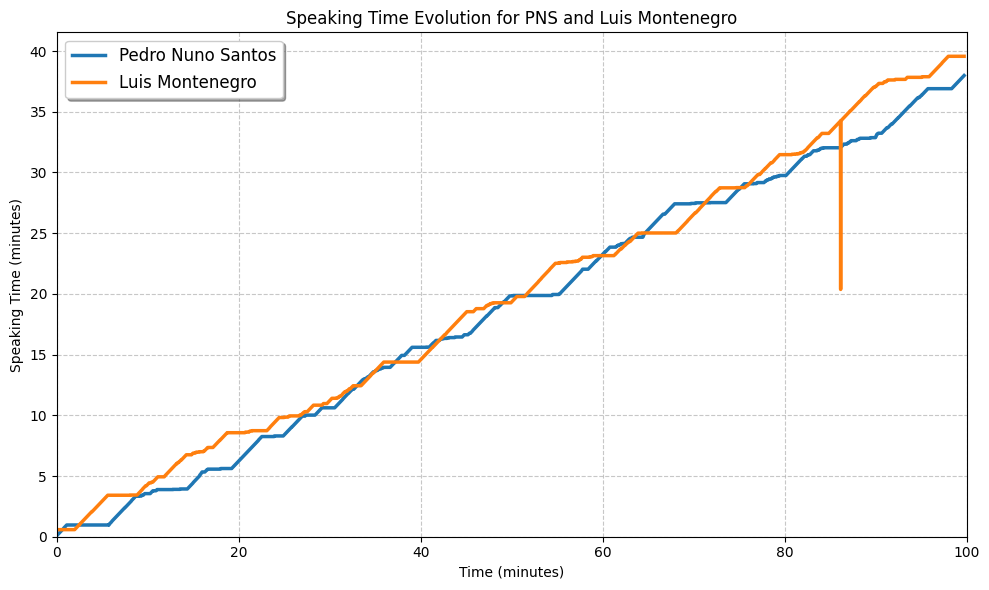

In [30]:

#first lets order the images

data = data.sort_values(by='filename')

count = 0

for i in range(len(data)):
    count = count +1
    print("count: " + str(count) + " data: " + str(data.iloc[i, 4]))

pd.set_option('display.max_rows', None)

Used_list = []


# Iterate over the rows of the DataFrame starting from index 73
for i in range(104, len(data)):

    # Extract the list from the specified column
    data_inside = data.iloc[i, 4]

    # Iterate over each string in the list
    for j in range(len(data_inside)):

        # Check if the pattern matches the string
        if re.search(pattern_n, data_inside[j]):
            

            # If pattern is found, extract the current string and the next three strings
            desired_info = data_inside[j:j+4]  # Extract the next three strings

            translated_info = []
            for item in desired_info:
                if re.match(pattern_n, item):
                    translated_info.append("Pedro Nuno Santos")
                elif re.match(pattern_mo, item):
                    translated_info.append("Luis Montenegro")
                else:
                    translated_info.append(item)

            # Append the translated_info to Used_list
            Used_list.append(translated_info)


# Filter out lists with exactly 4 objects
Used_list = [desired_info for desired_info in Used_list if len(desired_info) == 4]


# Initialize arrays to store Montenegro and PNS times
PNS1_times = []
Mo_times = []


for list in Used_list:
 
    # Get the first two characters
    first_part_m = list[1][:2]

    # Get the last two characters
    second_part_m = list[1][-2:]

    first_part_v = list[2][:2]

    second_part_v = list[2][-2:]
    
     # Join the PNS parts with a period in the middle
    PNS1_time = f"{first_part_m}.{second_part_m}"

    # Join the Mortagua parts with a period in the middle
    Mo_time = f"{first_part_v}.{second_part_v}"
    
    # Append the times to the arrays
    PNS1_times.append(PNS1_time)
    Mo_times.append(Mo_time)


PNS1_times = [time.replace('O', '0').replace('I', '1').replace('l', '1') for time in PNS1_times]
Mo_times = [time.replace('O', '0').replace('I', '1').replace('l', '1') for time in Mo_times]


PNS1_times_filtered = [time for time in PNS1_times if 'PS' not in time and 'Dt' not in time and 'So' not in time and 'R0' not in time and 'CD' not in time]
Mo_times_filtered = [time for time in Mo_times if 'R0' not in time and 'Ro' not in time and '{2' not in time and 'Pe' not in time and 'Lu' not in time and '[2' not in time and 'Ho' not in time and '@' not in time and '#' not in time and 'AN' not in time]

PNS1_minutes_filtered = [time_str_to_float(time) for time in PNS1_times_filtered]
Mo_minutes_filtered = [time_str_to_float(time) for time in Mo_times_filtered]


####################################### Plot the Filtered Data with Outliers Removed  #######################################

total_debate_time = 100  # Assuming the total time for the debate in minutes
total_speech_turns = max(len(PNS1_minutes_filtered), len(Mo_minutes_filtered))

# Calculate the average duration per speech turn in minutes, if you have a total count of turns
average_duration_per_turn = total_debate_time / total_speech_turns

# Generate x-axis values corresponding to the actual time in minutes
x_axis_time = [i * average_duration_per_turn for i in range(total_speech_turns)]

for i in range(0, len(PNS1_minutes_filtered)):
    if PNS1_minutes_filtered[i] == 82.4 or PNS1_minutes_filtered[i] == 1.0166666666666666:
        PNS1_minutes_filtered[i] = PNS1_minutes_filtered[i-2]

for i in range(0, len(Mo_minutes_filtered)):
    if Mo_minutes_filtered[i] == 82.4 or Mo_minutes_filtered[i] == 1.0166666666666666:
        Mo_minutes_filtered[i] = Mo_minutes_filtered[i-2]
       
PNS1_minutes_filtered = PNS1_minutes_filtered[:len(Mo_minutes_filtered)]

plt.figure(figsize=(10, 6))  # Specify the figure size for better visibility

#Mo_minutes_filtered=Mo_minutes_filtered[:len(PNS1_minutes_filtered)]

# Use the generated x-axis for both speakers to show actual time distribution across the debate
plt.plot(x_axis_time[:len(PNS1_minutes_filtered)], PNS1_minutes_filtered, label='Pedro Nuno Santos', linewidth=2.5)
plt.plot(x_axis_time[:len(Mo_minutes_filtered)], Mo_minutes_filtered, label='Luis Montenegro', linewidth=2.5)

plt.fill_between(x_axis_time[:min(len(PNS1_minutes_filtered), len(Mo_minutes_filtered))], 
                 PNS1_minutes_filtered[:min(len(PNS1_minutes_filtered), len(Mo_minutes_filtered))], 
                  PNS1_minutes_filtered[:min(len(PNS1_minutes_filtered), len(Mo_minutes_filtered))], color='grey', alpha=0.3)

# Add labels and title with more description
plt.xlabel('Time (minutes)')
plt.ylabel('Speaking Time (minutes)')
plt.title('Speaking Time Evolution for PNS and Luis Montenegro')

# Enhance the legend
plt.legend(loc='upper left', fontsize='large', frameon=True, shadow=True)

# Show the plot with an enhanced grid for better readability and axis range adjustment
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(left=0, right=total_debate_time)  # Adjust x-axis to cover the total debate duration
plt.ylim(bottom=0)  # Start y-axis at zero

plt.tight_layout()  # Adjust layout to fit elements neatly
plt.show()


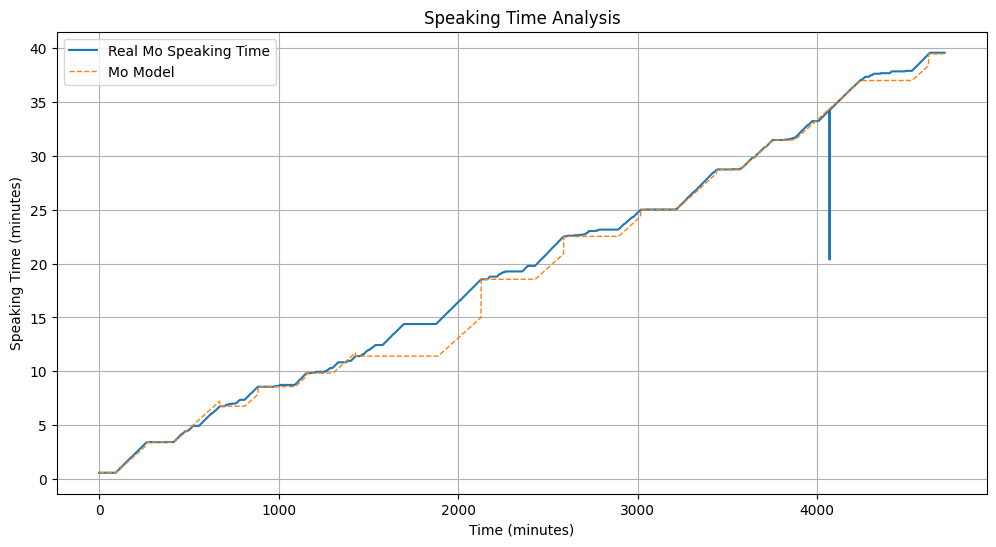

Mo Mean deviation: 1.3043819847690323


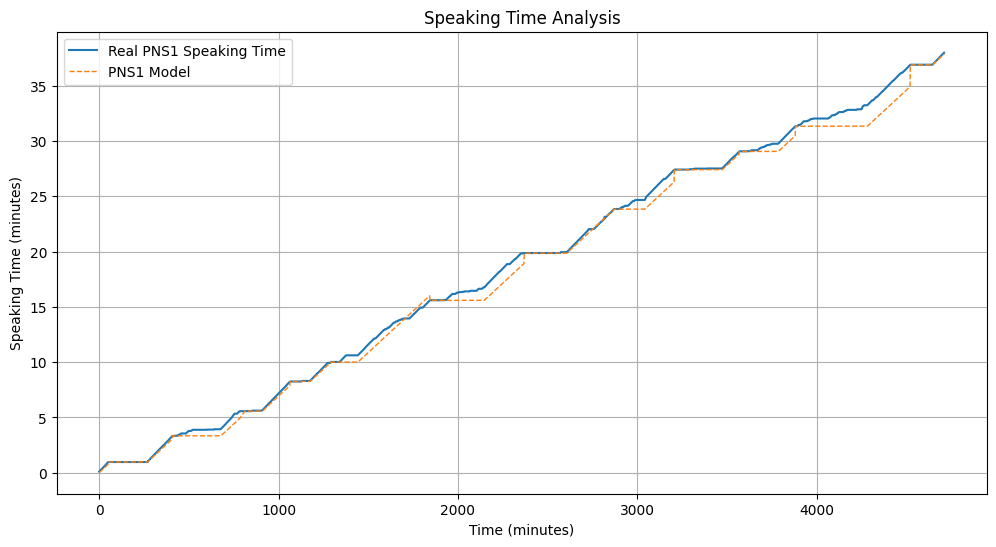

PNS1 Mean deviation: 0.5217467869103021


In [31]:
x_values9 = np.array([i for i in range(len(Mo_minutes_filtered))]) #Vai até 2230


segments_Mo = [
    (0, 92, 'c', Mo_minutes_filtered[0]),
    (93, 263, 'l', 0.015),
    (264, 416, 'c', Mo_minutes_filtered[264]),
    (417, 671, 'l', 0.015),
    (672, 810, 'c', Mo_minutes_filtered[672]),
    (811, 884, 'l', 0.015),
    (885, 1090, 'c', Mo_minutes_filtered[885]),
    (1091, 1154, 'l', 0.015),
    (1155, 1300, 'c', Mo_minutes_filtered[1155]),
    (1301, 1427, 'l', 0.015),
    (1430, 1877, 'c', Mo_minutes_filtered[1430]),
    (1888, 2127, 'l', 0.015),
    (2128, 2428, 'c', Mo_minutes_filtered[2128]),
    (2429, 2587, 'l', 0.015),
    (2588, 2892, 'c', Mo_minutes_filtered[2588]),
    (2893, 3016, 'l', 0.015),
    (3017, 3214, 'c', Mo_minutes_filtered[3017]),
    (3215, 3439, 'l', 0.015),
    (3440, 3571, 'c', Mo_minutes_filtered[3440]),
    (3572, 3751, 'l', 0.015),
    (3752, 3874, 'c', Mo_minutes_filtered[3752]),
    (3875, 4237, 'l', 0.015),
    (4238, 4527, 'c', Mo_minutes_filtered[4238]),
    (4528, 4620, 'l', 0.015),
    (4621, 4709, 'c', Mo_minutes_filtered[4621])
]

segments_PNS1 = [
    (0, 50, 'l', 0.015),
    (51, 268, 'c', PNS1_minutes_filtered[51]),
    (269, 408, 'l', 0.015),
    (409, 677, 'c', PNS1_minutes_filtered[409]),
    (678, 784, 'l', 0.015),
    (811, 908, 'c', PNS1_minutes_filtered[811]),
    (909, 1063, 'l', 0.015),
    (1064, 1174, 'c', PNS1_minutes_filtered[1064]),
    (1175, 1291, 'l', 0.015),
    (1292, 1441, 'c', PNS1_minutes_filtered[1292]),
    (1442, 1842, 'l', 0.015),
    (1843, 2145, 'c', PNS1_minutes_filtered[1843]),
    (2146, 2368, 'l', 0.015),
    (2369, 2605, 'c', PNS1_minutes_filtered[2369]),
    (2606, 2869, 'l', 0.015),
    (2870, 3040, 'c', PNS1_minutes_filtered[2870]),
    (3041, 3205, 'l', 0.015),
    (3206, 3472, 'c', PNS1_minutes_filtered[3206]),
    (3473, 3567, 'l', 0.015),
    (3568, 3784, 'c', PNS1_minutes_filtered[3568]),
    (3785, 3880, 'l', 0.015),
    (3881, 4281, 'c', PNS1_minutes_filtered[3881]),  
    (4282, 4520, 'l', 0.015),
    (4521, 4644, 'c', PNS1_minutes_filtered[4521]),
    (4645, 4713, 'l', 0.015)
]


# Compute piecewise functions
x_custom_Mo, y_custom_Mo = calculate_custom_function_affine(segments_Mo)
x_custom_PNS1, y_custom_PNS1 = calculate_custom_function_affine(segments_PNS1)

# Ensure equal lengths for plotting if necessary
if len(x_custom_Mo) > len(x_custom_PNS1):
    x_custom_Mo = x_custom_Mo[:len(x_custom_PNS1)]
    y_custom_Mo = y_custom_Mo[:len(y_custom_PNS1)]

if len(x_custom_PNS1) > len(x_custom_Mo):
    x_custom_PNS1 = x_custom_PNS1[:len(x_custom_Mo)]
    y_custom_PNS1 = y_custom_PNS1[:len(y_custom_Mo)]

# Plotting and analysis
plot_and_analyze_speaking_time(x_values9, Mo_minutes_filtered, x_custom_Mo, y_custom_Mo, "Mo")
plot_and_analyze_speaking_time(x_values9, PNS1_minutes_filtered, x_custom_PNS1, y_custom_PNS1, "PNS1")


AD vs IL  --> SIC

In [32]:
# Load the pickle file into a DataFrame
data = pd.read_pickle('pkl_files\\ad-il.pkl')

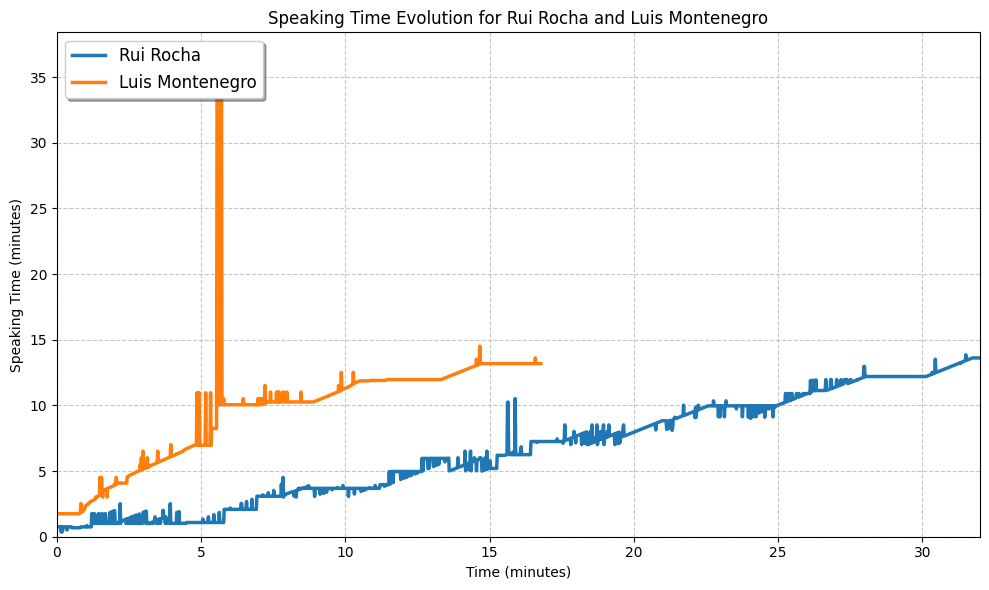

In [33]:

#first lets order the images

data = data.sort_values(by='filename')

count = 0

pd.set_option('display.max_rows', None)

Used_list = []

pattern_Rocha= r'\bR\w+\b'

pattern_LuisMontenegro = r'\bL\w+\b'


# Iterate over the rows of the DataFrame starting from index 73
for i in range(208, len(data)):

    # Extract the list from the specified column
    data_inside = data.iloc[i, 4]

    # Iterate over each string in the list
    for j in range(len(data_inside)):

        # Check if the pattern matches the string
        if re.search(pattern_Rocha, data_inside[j]):
            

            # If pattern is found, extract the current string and the next three strings
            desired_info = data_inside[j:j+4]  # Extract the next three strings

            translated_info = []
            for item in desired_info:
                if re.match(pattern_Rocha, item):
                    translated_info.append("Rui Rocha")
                elif re.match(pattern_LuisMontenegro, item):
                    translated_info.append("Luis Montenegro")
                else:
                    translated_info.append(item)

            # Append the translated_info to Used_list
            Used_list.append(translated_info)


# Filter out lists with exactly 4 objects
Used_list = [desired_info for desired_info in Used_list if len(desired_info) == 4]


# Initialize arrays to store Montenegro and PNS times
RR_times = []
LM_times = []


for list in Used_list:
 
    # Get the first two characters
    first_part_m = list[1][:2]

    # Get the last two characters
    second_part_m = list[1][-2:]

    first_part_v = list[2][:2]

    second_part_v = list[2][-2:]
    
     # Join the PNS parts with a period in the middle
    RR_time = f"{first_part_m}.{second_part_m}"

    # Join the Mortagua parts with a period in the middle
    LM_time = f"{first_part_v}.{second_part_v}"
    
    # Append the times to the arrays
    RR_times.append(RR_time)
    LM_times.append(LM_time)


RR_times = [time.replace('O', '0').replace('I', '1').replace('l', '1').replace('o', '0').replace('|', '1').replace('[', '1').replace('/', '1').replace(']', '1') for time in RR_times]
LM_times = [time.replace('O', '0').replace('I', '1').replace('l', '1').replace('o', '0').replace('|', '1').replace('[', '1').replace('/', '1').replace(']', '1') for time in LM_times]


RR_times_filtered = [time for time in RR_times if "Ad" not in time and " _" not in time and "AD" not in time and " :" not in time and "Ru" not in time]
LM_times_filtered = [time for time in LM_times if 'R0' not in time and 'Ro' not in time and '{2' not in time and 'Pe' not in time and 'Lu' not in time and '[2' not in time and 'Ho' not in time and '@' not in time and '#' not in time and 'AN' not in time]

RR_minutes_filtered = [time_str_to_float(time) for time in RR_times_filtered]
LM_minutes_filtered = [time_str_to_float(time) for time in LM_times_filtered]


####################################### Plot the Filtered Data with Outliers Removed  #######################################

total_debate_time = 32  # Assuming the total time for the debate in minutes
total_speech_turns = max(len(RR_minutes_filtered), len(LM_minutes_filtered))

# Calculate the average duration per speech turn in minutes, if you have a total count of turns
average_duration_per_turn = total_debate_time / total_speech_turns

# Generate x-axis values corresponding to the actual time in minutes
x_axis_time = [i * average_duration_per_turn for i in range(total_speech_turns)]
       
plt.figure(figsize=(10, 6))  # Specify the figure size for better visibility

#Mo_minutes_filtered=Mo_minutes_filtered[:len(PNS1_minutes_filtered)]

# Use the generated x-axis for both speakers to show actual time distribution across the debate
plt.plot(x_axis_time[:len(RR_minutes_filtered)], RR_minutes_filtered, label='Rui Rocha', linewidth=2.5)
plt.plot(x_axis_time[:len(LM_minutes_filtered)], LM_minutes_filtered, label='Luis Montenegro', linewidth=2.5)

plt.fill_between(x_axis_time[:min(len(RR_minutes_filtered), len(LM_minutes_filtered))], 
                 RR_minutes_filtered[:min(len(RR_minutes_filtered), len(LM_minutes_filtered))], 
                  RR_minutes_filtered[:min(len(RR_minutes_filtered), len(LM_minutes_filtered))], color='grey', alpha=0.3)

# Add labels and title with more description
plt.xlabel('Time (minutes)')
plt.ylabel('Speaking Time (minutes)')
plt.title('Speaking Time Evolution for Rui Rocha and Luis Montenegro')

# Enhance the legend
plt.legend(loc='upper left', fontsize='large', frameon=True, shadow=True)

# Show the plot with an enhanced grid for better readability and axis range adjustment
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(left=0, right=total_debate_time)  # Adjust x-axis to cover the total debate duration
plt.ylim(bottom=0)  # Start y-axis at zero

plt.tight_layout()  # Adjust layout to fit elements neatly
plt.show()


A debate from SIC, like you can see, is impossible to do the same text analysis...